<a href="https://colab.research.google.com/github/Vagarh/Master-in-Data-Science-assignments/blob/main/Taller_1_Prediccion_de_un_activo_financiero_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Packages

# Imporing Libraries

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math
import statsmodels.api as sm

from datetime import datetime
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

# Importing Dataset

In [3]:
today = date.today()
end_date = "2024-03-25"

d1 = date.today() - timedelta(days=1460)
start_date = "2020-01-01"

data = yf.download('GOOG',
                      start=start_date,
                      end=end_date,
                      progress=False)
data["Date"] = data.index
df = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df.reset_index(drop=True, inplace=True)
print(df.tail())

           Date        Open        High         Low       Close   Adj Close  \
1058 2024-03-18  149.369995  152.929993  148.139999  148.479996  148.479996   
1059 2024-03-19  148.979996  149.619995  147.009995  147.919998  147.919998   
1060 2024-03-20  148.789993  149.759995  147.664993  149.679993  149.679993   
1061 2024-03-21  150.320007  151.304993  148.009995  148.740005  148.740005   
1062 2024-03-22  150.240005  152.559998  150.089996  151.770004  151.770004   

        Volume  
1058  47676700  
1059  17748400  
1060  17730000  
1061  19843900  
1062  19226300  


In [4]:
data = data[["Date", "Close"]]
data.set_index("Date", inplace=True)
#data = data[ "Close"]
data.head()

Close
Date                 
2020-01-02  68.368500
2020-01-03  68.032997
2020-01-06  69.710503
2020-01-07  69.667000
2020-01-08  70.216003

In [5]:
data.dtypes


Close    float64
dtype: object

In [6]:
data.describe()

Close
count  1063.000000
mean    110.430818
std      26.017205
min      52.831001
25%      89.009499
50%     113.396004
75%     134.149002
max     154.839996

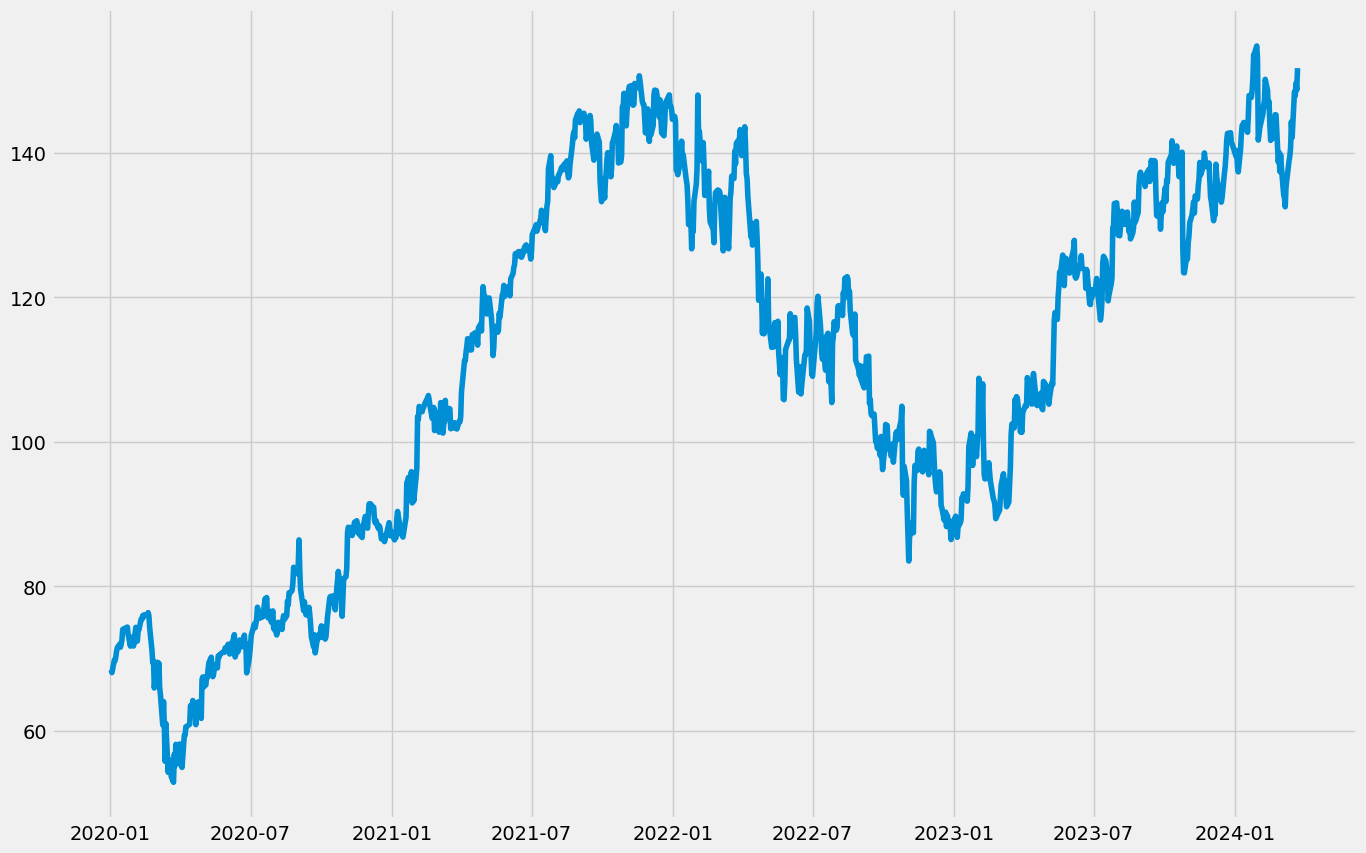

In [7]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data.index, data["Close"])

# Seasonal_decompose

<Figure size 640x480 with 0 Axes>

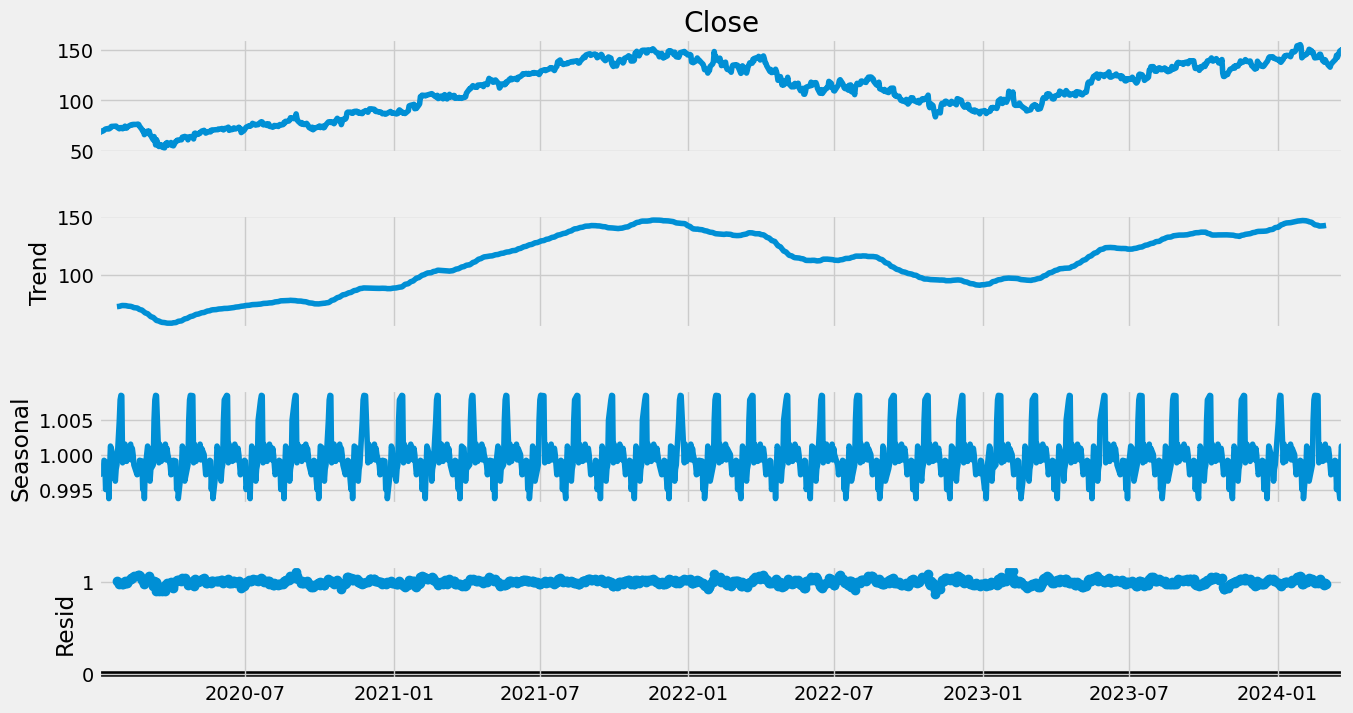

In [8]:
lim_data = data["Close"]
result = seasonal_decompose(lim_data,
                            model='multiplicative',
                            period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 8)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

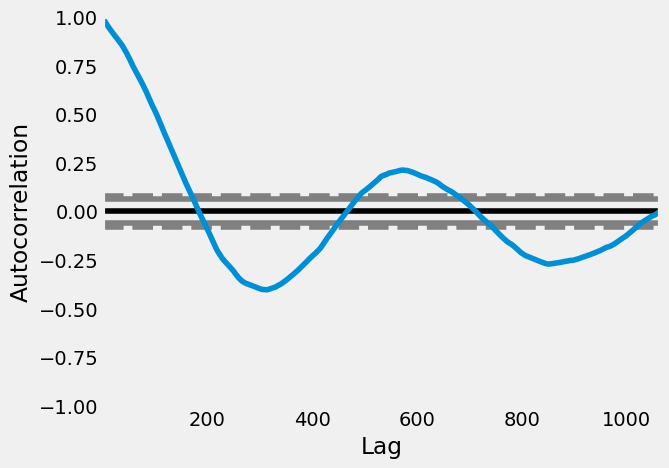

In [9]:
pd.plotting.autocorrelation_plot(data["Close"])

# Stationarity:ACF and PACF plots

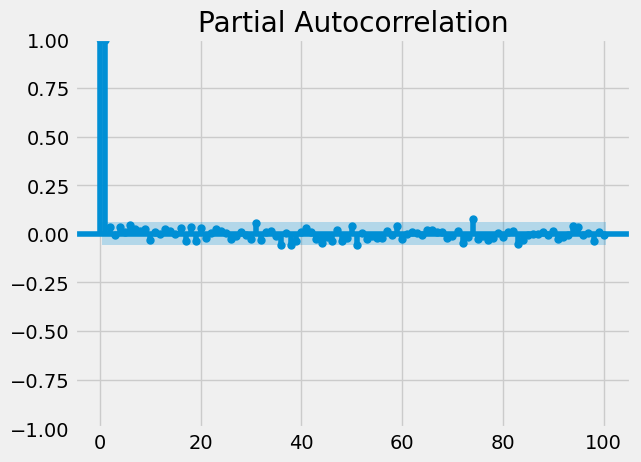

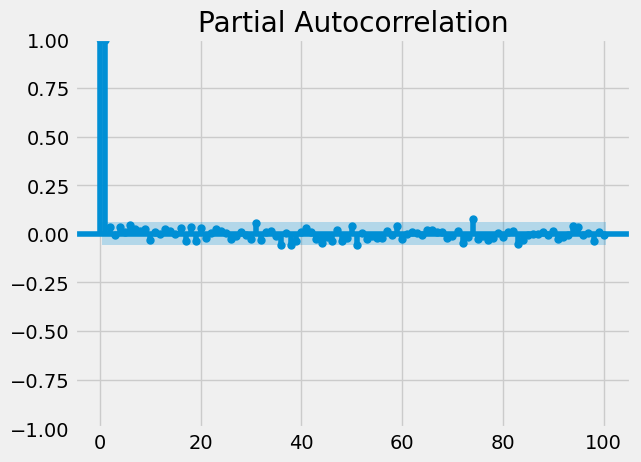

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

In [11]:
def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [12]:
check_stationarity(data['Close'])

ADF Statistic: -1.389296
p-value: 0.587397
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Non-stationary


## Transformation Techniques

Clearly this series is Non-Stationary. So before applying the ARIMA and SARIMA Models, we tranform this series to Stationary using the following transofrmations.

### Log Transformation

In [13]:
data['Close_log'] = np.log(data["Close"].values)

check_stationarity(data['Close_log'])

ADF Statistic: -1.334793
p-value: 0.613108
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Non-stationary


### Differencing

In [14]:
data['Close_diff'] = data['Close'].diff().fillna(0)

check_stationarity(data['Close_diff'])

ADF Statistic: -33.872409
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Stationary


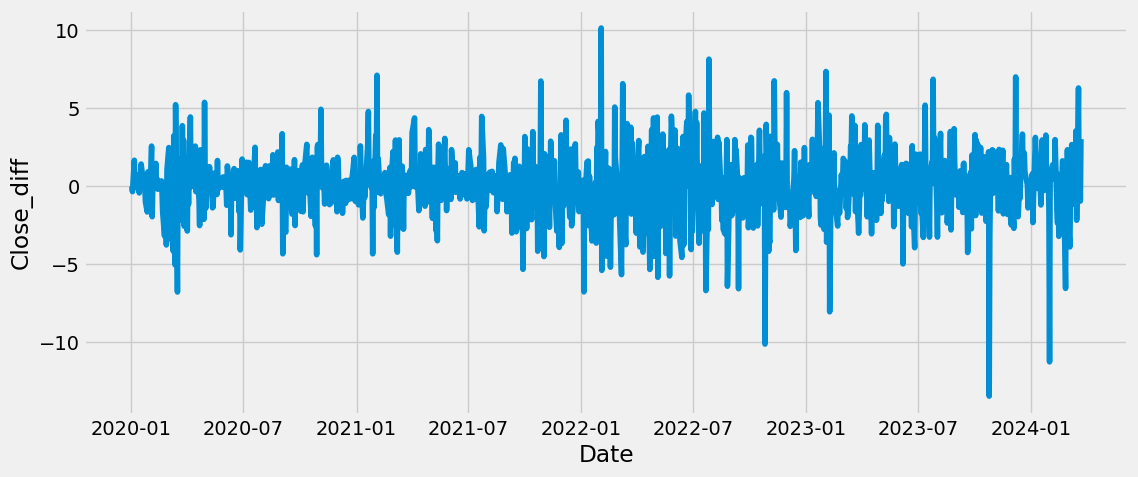

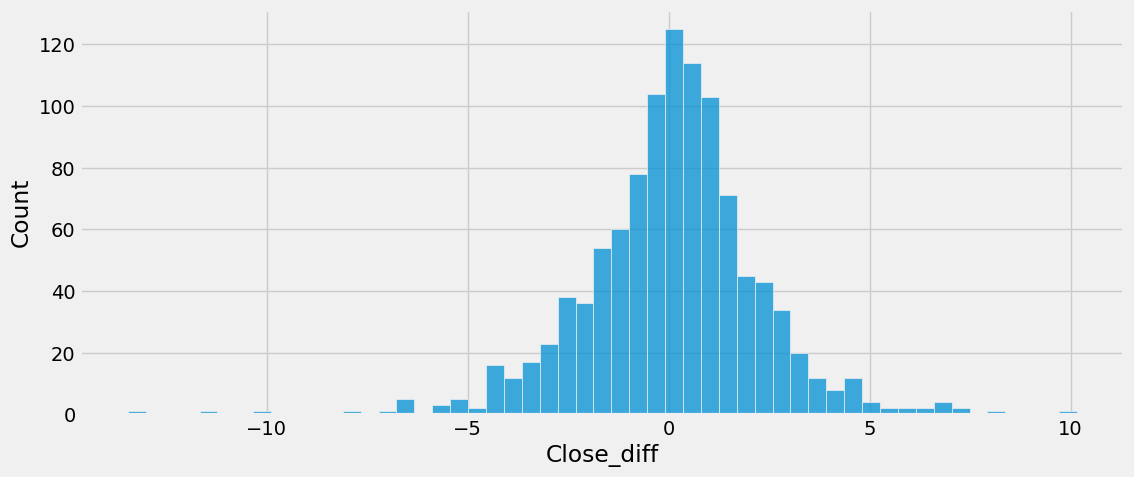

In [15]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.lineplot(data=data, x=data.index, y='Close_diff')
plt.show()

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.histplot(data['Close_diff'] )
plt.show()

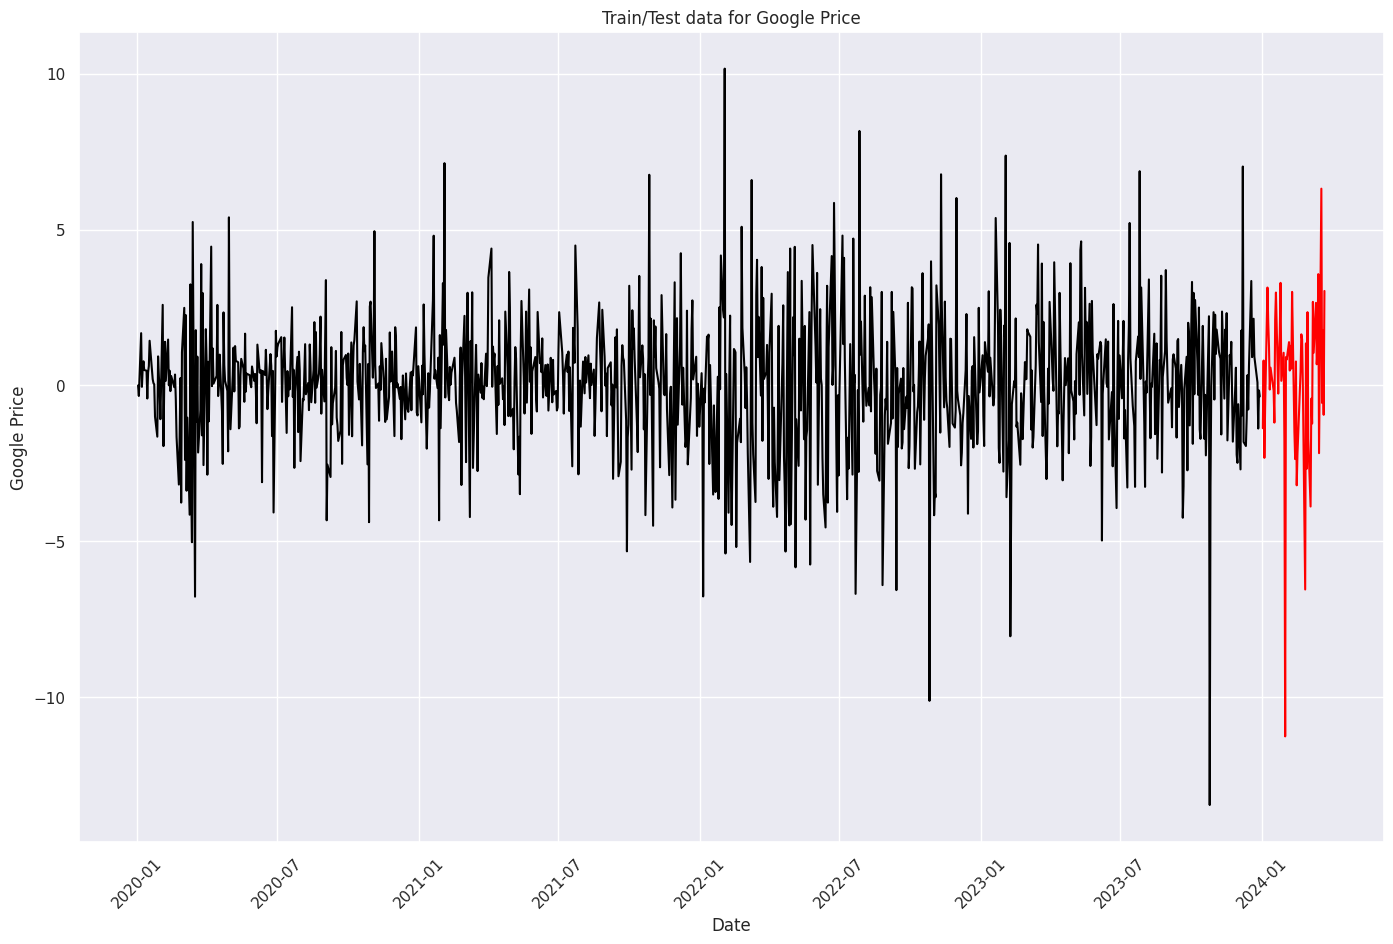

In [16]:
train = data[data.index<pd.to_datetime("2024-01-01",format = "%Y-%m-%d")]
test = data[data.index>pd.to_datetime("2024-01-01",format = "%Y-%m-%d")]
train = train[['Close_diff']]
test = test[['Close_diff']]
sns.set()
plt.subplots(figsize = (15,10))
plt.plot(train,color ='black')
plt.plot(test,color = 'red')
plt.ylabel("Google Price")
plt.xlabel("Date")
plt.xticks(rotation = 45)
plt.title("Train/Test data for Google Price")
plt.show()

## ACF and PACF Stationary Time Series

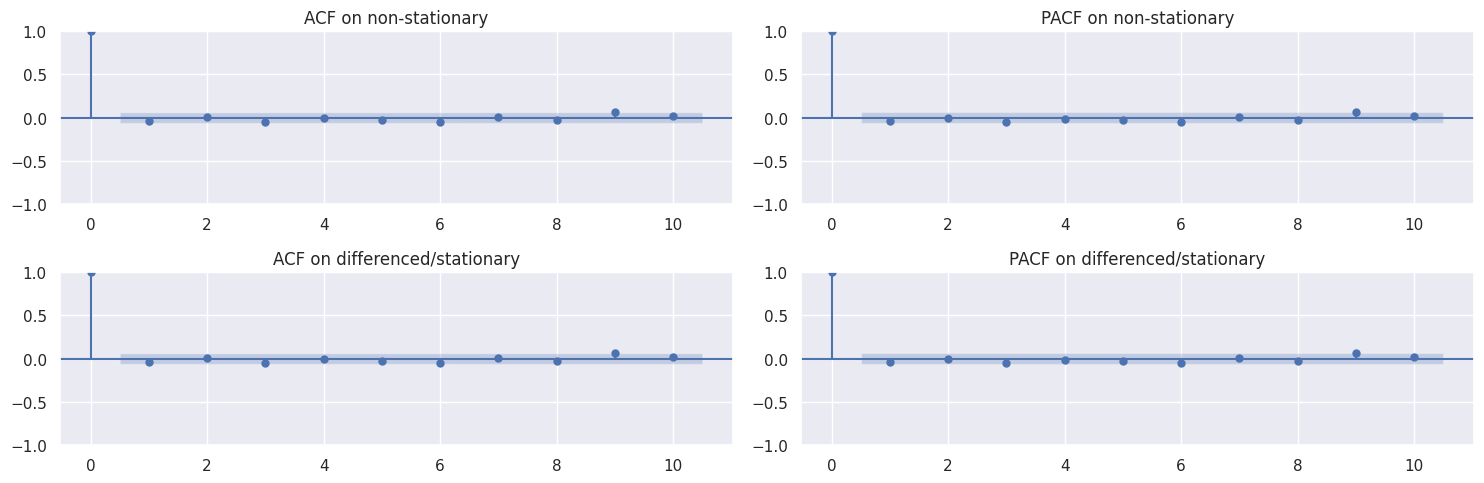

In [17]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,5))

plot_acf(train['Close_diff'], lags=10, ax=ax[0, 0], title='ACF on non-stationary')
plot_pacf(train['Close_diff'], lags=10, ax=ax[0, 1], method='ols', title='PACF on non-stationary')

plot_acf(train['Close_diff'], lags=10, ax=ax[1, 0], title='ACF on differenced/stationary')
plot_pacf(train['Close_diff'], lags=10, ax=ax[1, 1], method='ols', title='PACF on differenced/stationary')

plt.tight_layout()
plt.show()

# Model Building

## Grid Search Best_params

In [18]:
# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values,
                                            d_values,
                                            q_values,
                                            P_values,
                                            D_values,
                                            Q_values,
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]

    try:
        model = sm.tsa.SARIMAX(train["Close_diff"],
                               order=order,
                               seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic

        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)

            if aic < best_aic:
                best_aic = aic
                best_params = params

        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(0, 0, 0) (0, 0, 0, 12) 4409.203652113522
(0, 0, 0) (0, 0, 1, 12) 4410.089780949698
(0, 0, 0) (1, 0, 0, 12) 4410.068184158019
(0, 0, 0) (1, 0, 1, 12) 4412.021254082856
(0, 0, 1) (0, 0, 0, 12) 4409.431587943051
(0, 0, 1) (0, 0, 1, 12) 4410.302519103971
(0, 0, 1) (1, 0, 0, 12) 4410.2779787329855
(0, 0, 1) (1, 0, 1, 12) 4412.225023095377
(0, 0, 2) (0, 0, 0, 12) 4411.430791761424
(0, 0, 2) (0, 0, 1, 12) 4412.302187682703
(0, 0, 2) (1, 0, 0, 12) 4412.277711748307
(0, 0, 2) (1, 0, 1, 12) 4414.224937247665
(1, 0, 0) (0, 0, 0, 12) 4409.430316856071
(1, 0, 0) (0, 0, 1, 12) 4410.300114676135
(1, 0, 0) (1, 0, 0, 12) 4410.275361294131
(1, 0, 0) (1, 0, 1, 12) 4412.221510740188
(1, 0, 1) (0, 0, 0, 12) 4411.085269974117
(1, 0, 1) (0, 0, 1, 12) 4411.92483753028
(1, 0, 1) (1, 0, 0, 12) 4411.89708670827
(1, 0, 1) (1, 0, 1, 12) 4413.831379919575
(1, 0, 2) (0, 0, 0, 12) 4411.054132785606
(1, 0, 2) (0, 0, 1, 12) 4412.216876367003
(1, 0, 2) (1, 0, 0, 12) 4412.198571159222
(1, 0, 2) (1, 0, 1, 12) 4414.152481

In [19]:
# import necessary libraries
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# get actual data for county Polk
data_actual = train['Close_diff']

# set seasonal to True
seasonal = True

# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(data_actual,
                      m=12,               # frequency of series
                      seasonal=seasonal,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=4412.845, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4410.084, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4410.983, Time=0.56 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4411.004, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4409.204, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=4410.883, Time=0.35 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=4410.904, Time=0.42 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4410.211, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=4410.208, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=4411.902, Time=0.90 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 4.547 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:                        SARIMAX   Log Likelih

# ARIMA

In [20]:
def check_order(p,d,q):
    y = train['Close_diff']
    from statsmodels.tsa.arima.model import ARIMA
    ARIMAmodel = ARIMA(y, order = (p,d,q))
    ARIMAmodel = ARIMAmodel.fit()
    print(ARIMAmodel.summary(),"\n")

    y_pred = ARIMAmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"]


    from sklearn.metrics import mean_squared_error
    arima_rmse = np.sqrt(mean_squared_error(test['Close_diff'].values, y_pred_df["Predictions"]))
    print("RMSE: ",arima_rmse,'\n')

    ARIMAmodel.plot_diagnostics(figsize = (20,12))


    sns.set()
    plt.subplots(figsize = (15,5))
    plt.plot(train,color ='black',label = 'Train')
    plt.plot(test,color = 'red',label = 'Test')
    plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
    plt.ylabel("Gold Price")
    plt.xlabel("Date")
    plt.xticks(rotation = 45)
    plt.title("Train/Test and predictions for Gold Price")
    plt.tight_layout()
    plt.show()

## check_order(0,0,0)

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1006
Model:                          ARIMA   Log Likelihood               -2203.042
Date:                Wed, 27 Mar 2024   AIC                           4410.084
Time:                        02:53:43   BIC                           4419.912
Sample:                             0   HQIC                          4413.818
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0721      0.069      1.052      0.293      -0.062       0.207
sigma2         4.6737      0.131     35.671      0.000       4.417       4.930
Ljung-Box (L1) (Q):                   1.88   Jarque-

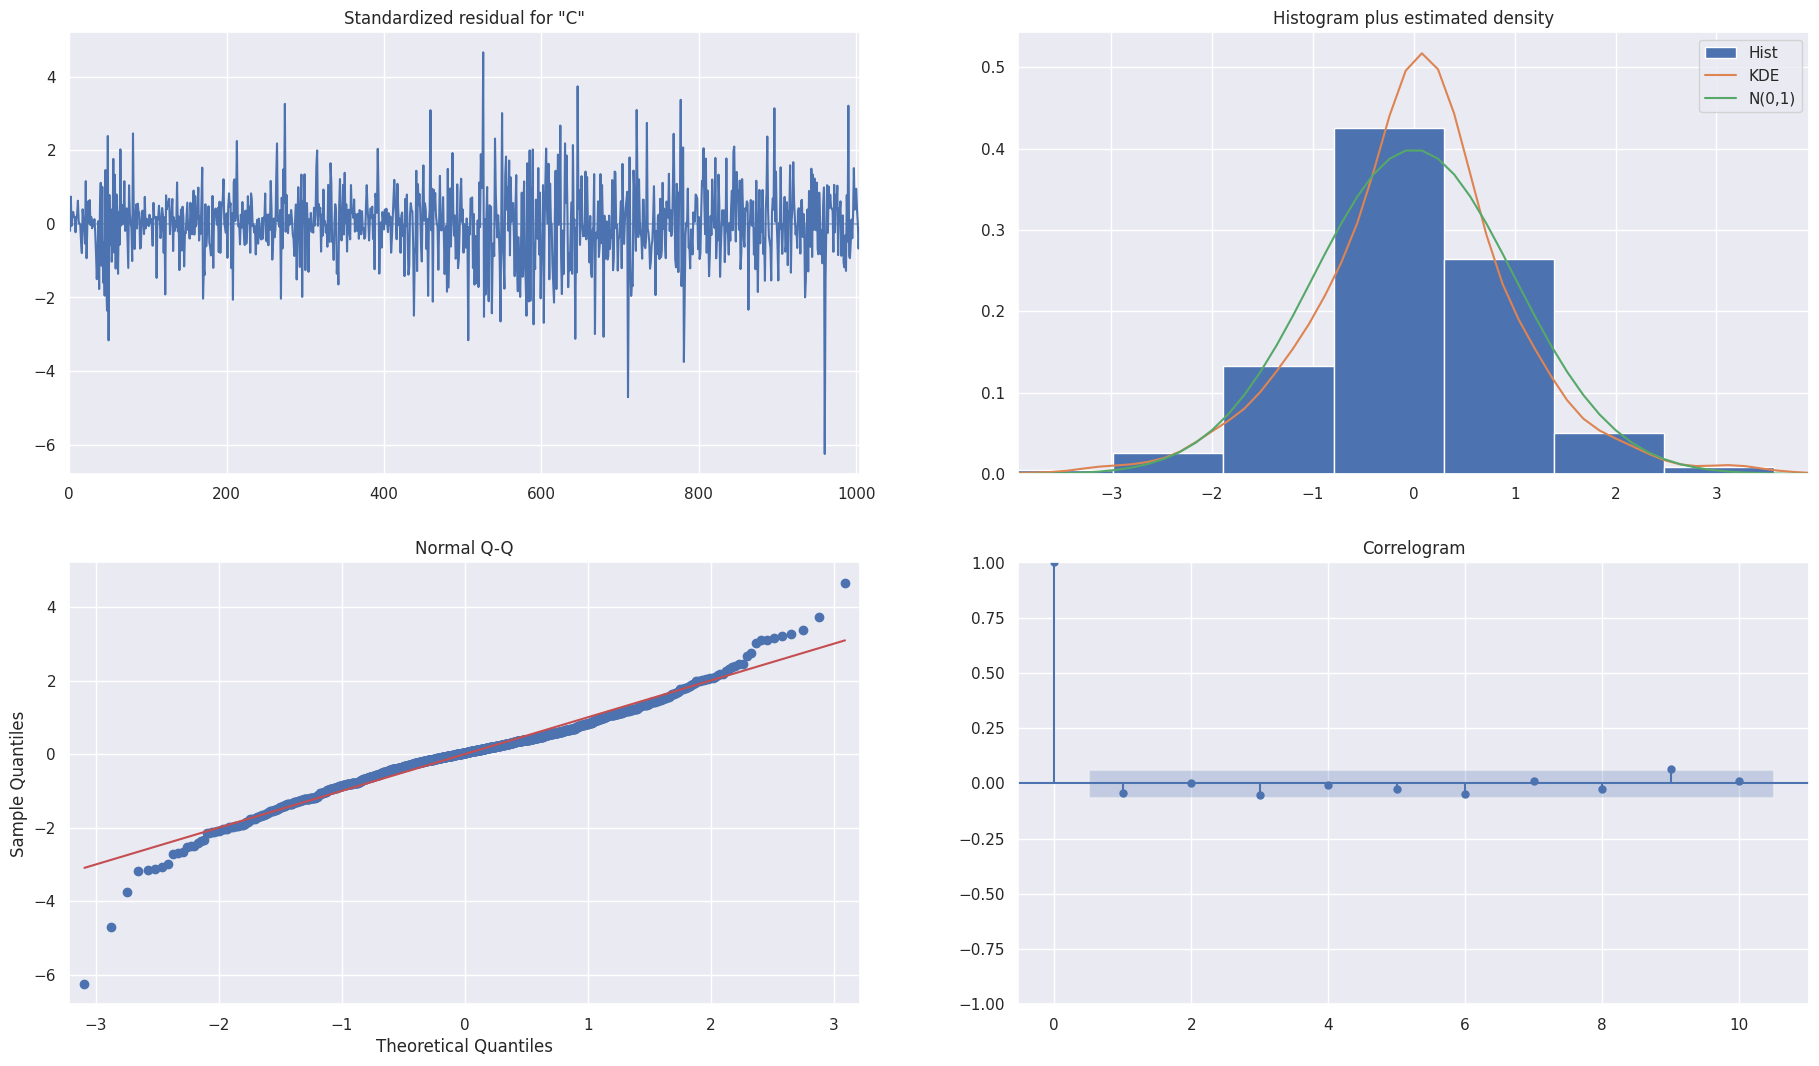

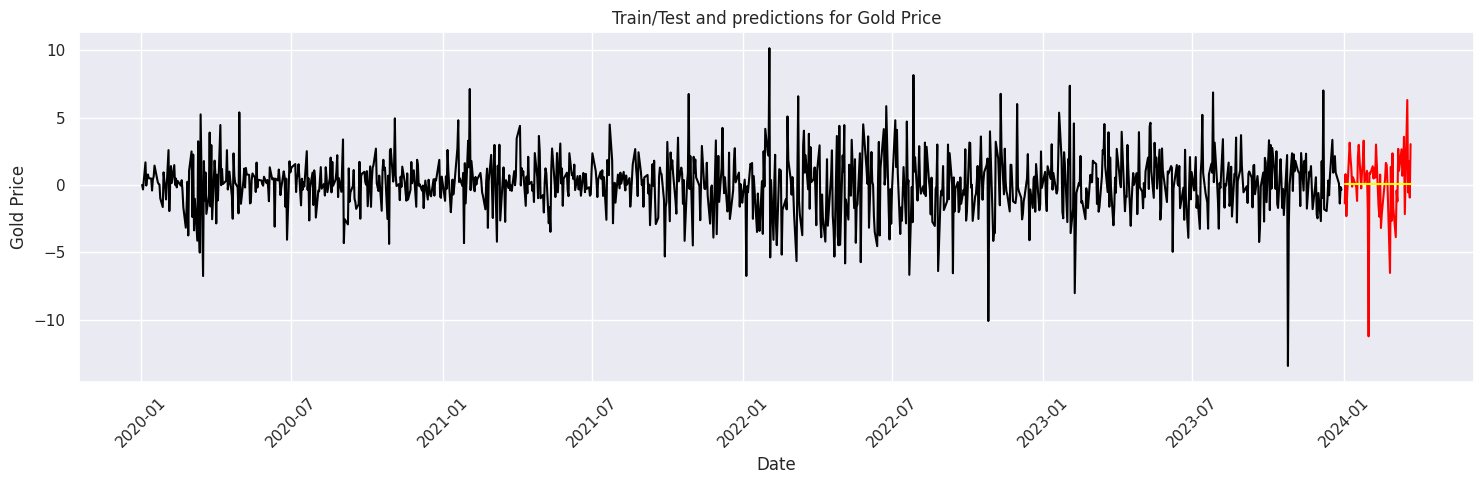

In [21]:
check_order(0,0,0)

## check_order(0,1,0)

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1006
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2570.879
Date:                Wed, 27 Mar 2024   AIC                           5143.758
Time:                        02:53:46   BIC                           5148.670
Sample:                             0   HQIC                          5145.624
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.7600      0.305     32.007      0.000       9.162      10.358
Ljung-Box (L1) (Q):                 274.40   Jarque-Bera (JB):               199.22
Prob(Q):                              0.00   Pr

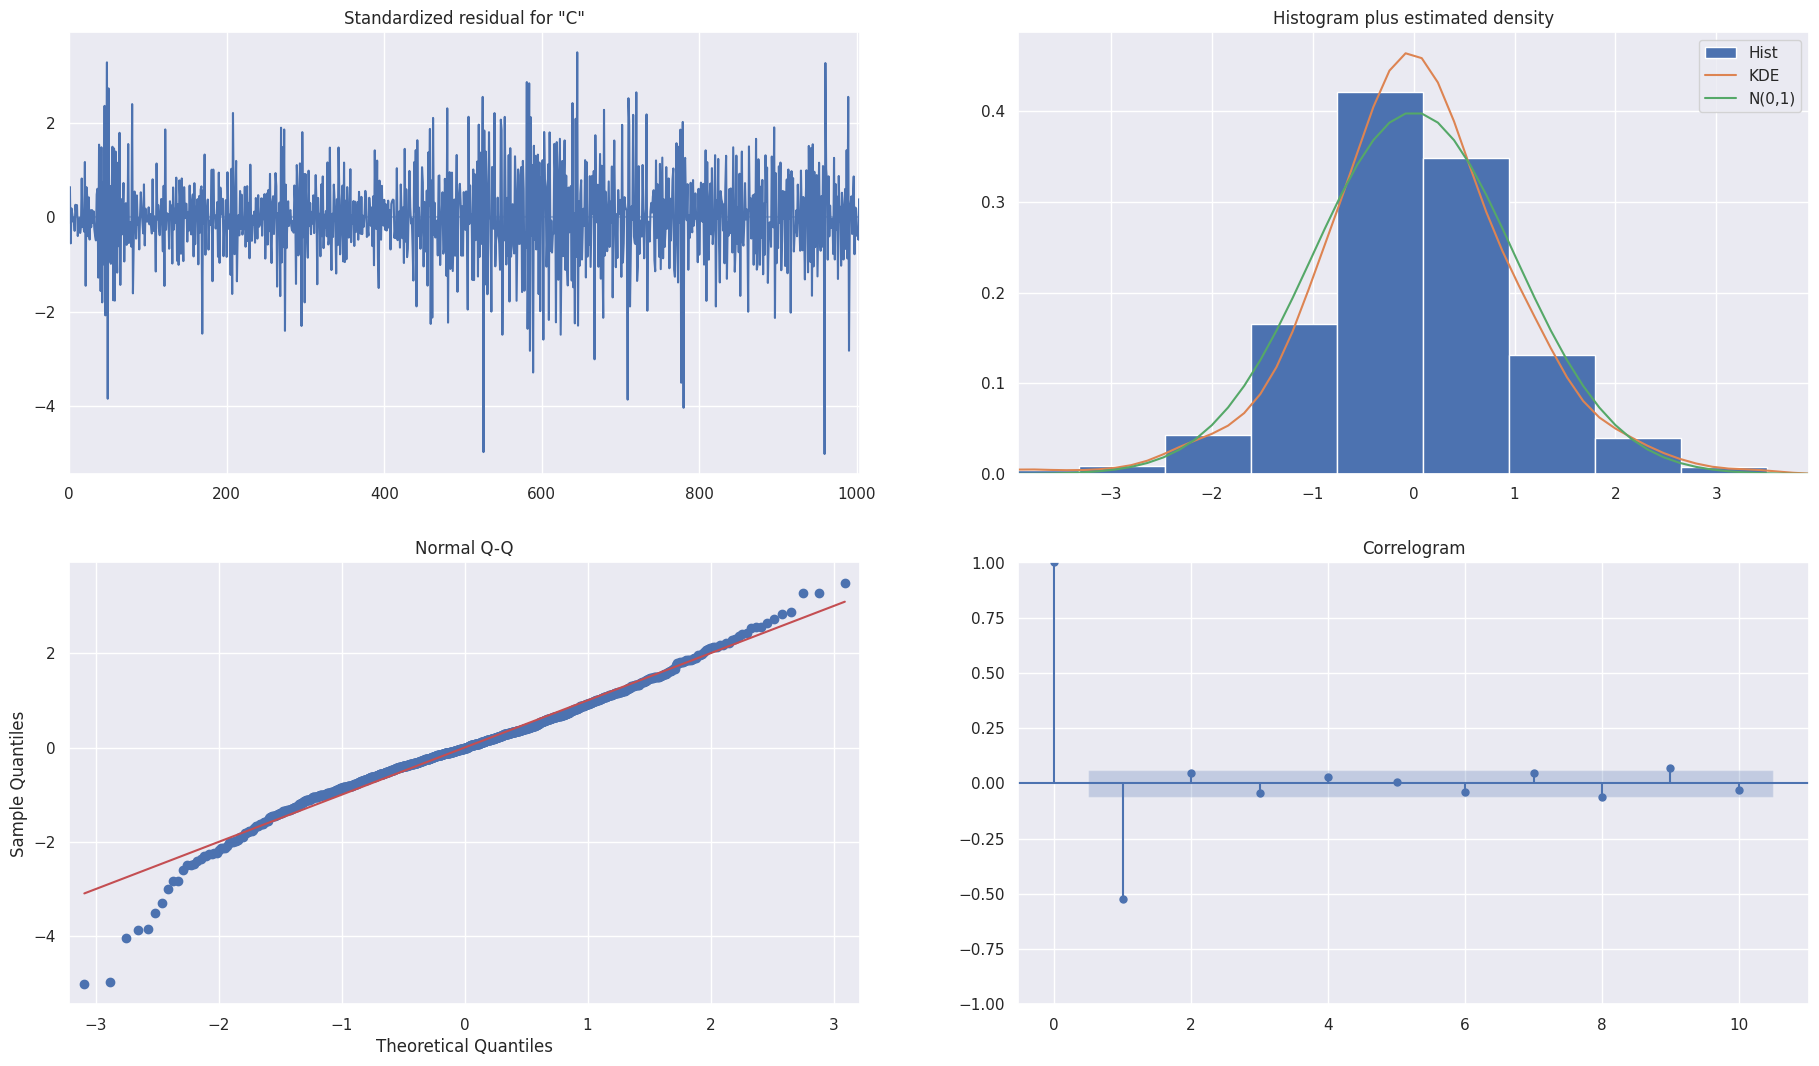

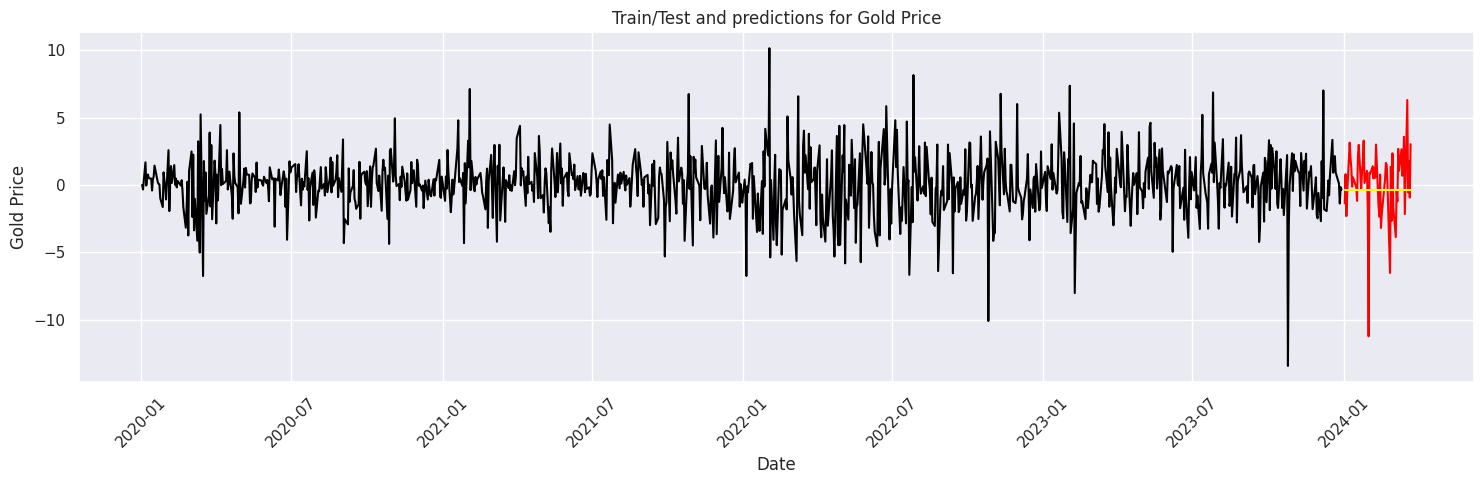

In [22]:
check_order(0,1,0)

## check_order(2,1,2)

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1006
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2203.561
Date:                Wed, 27 Mar 2024   AIC                           4417.122
Time:                        02:53:50   BIC                           4441.686
Sample:                             0   HQIC                          4426.456
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0318      0.036    -28.832      0.000      -1.102      -0.962
ar.L2         -0.0456      0.027     -1.677      0.094      -0.099       0.008
ma.L1         -0.0098      0.164     -0.060      0.9

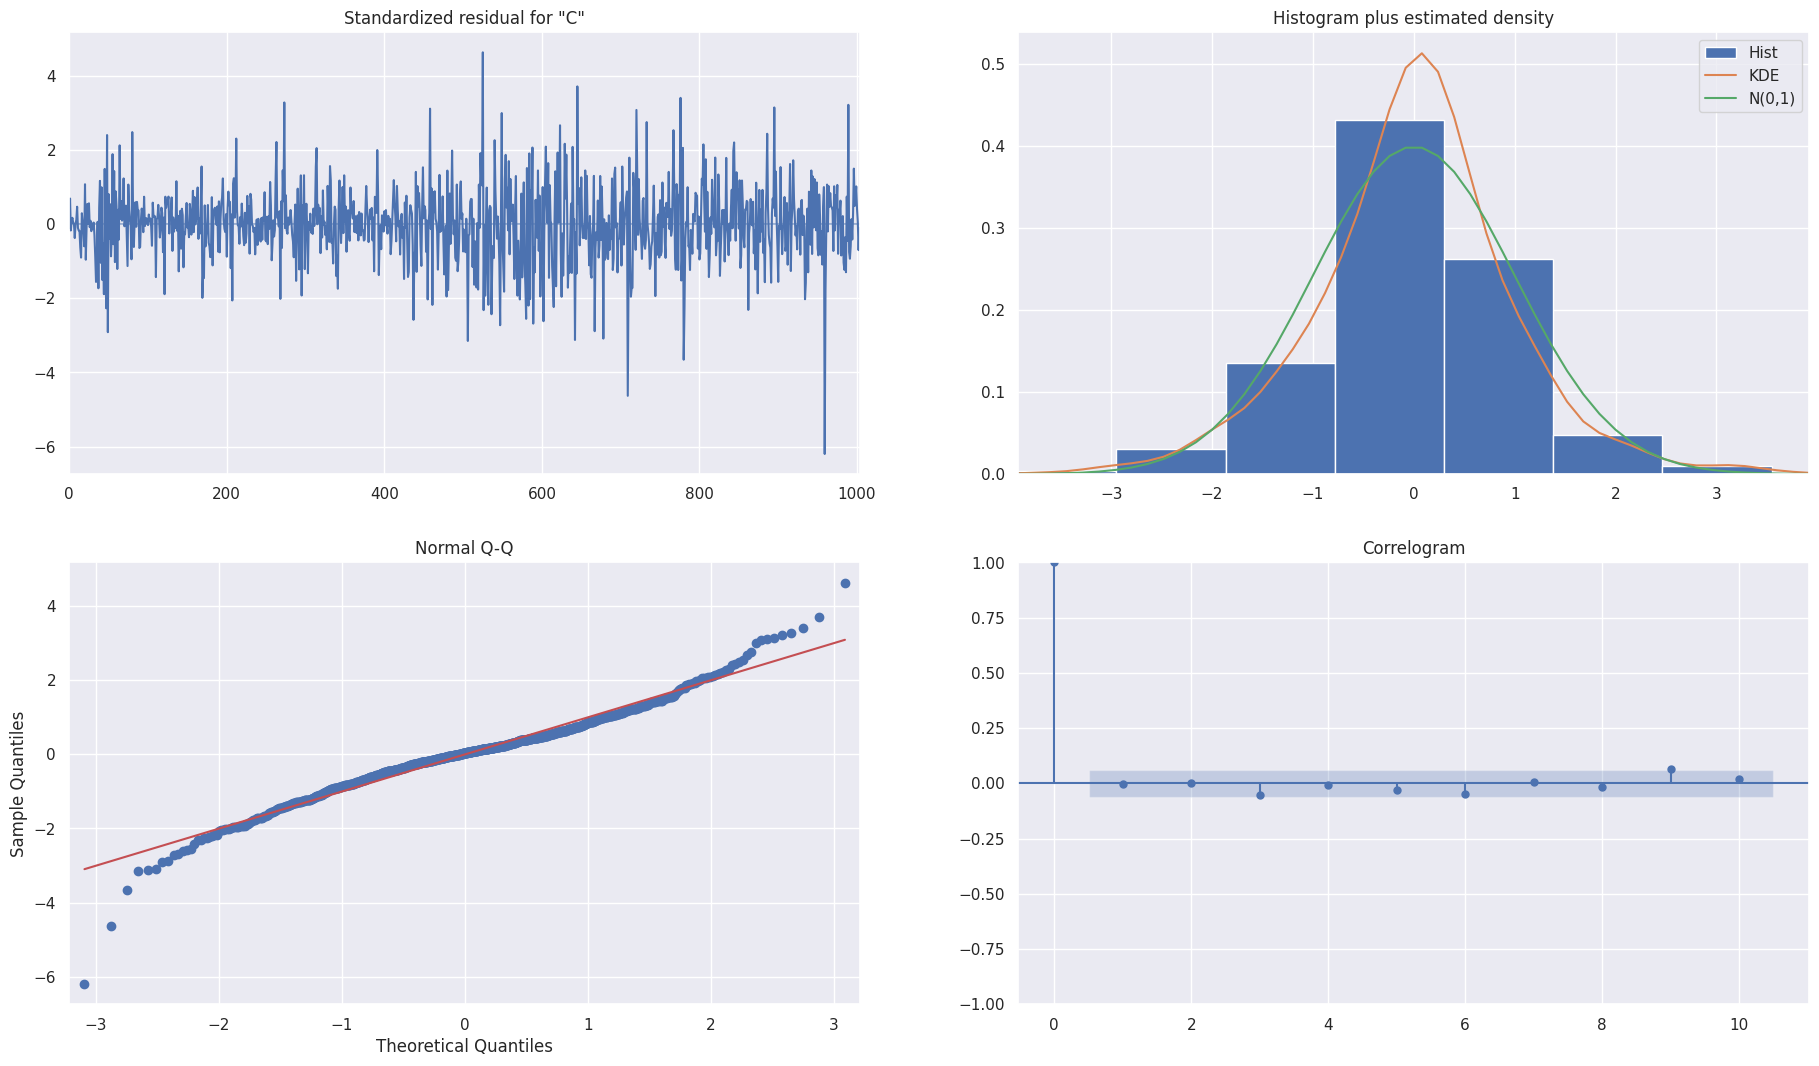

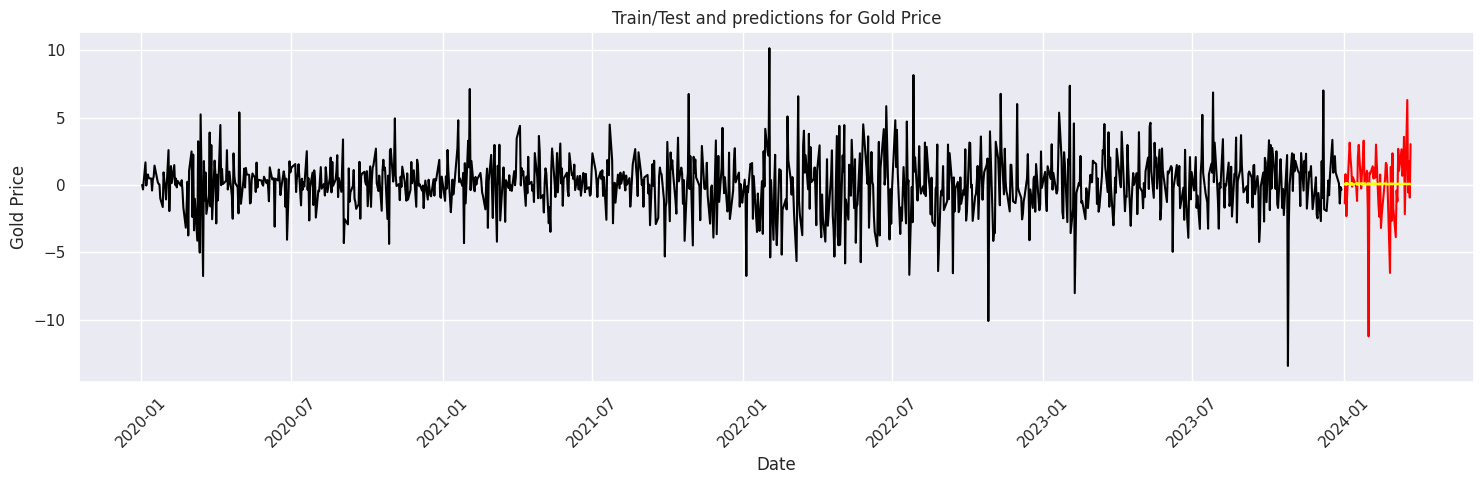

In [23]:
check_order(2,1,2)

## check_order(1,1,2)

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1006
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2202.735
Date:                Wed, 27 Mar 2024   AIC                           4413.469
Time:                        02:53:53   BIC                           4433.120
Sample:                             0   HQIC                          4420.936
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8448      0.112      7.561      0.000       0.626       1.064
ma.L1         -1.8789      0.099    -18.986      0.000      -2.073      -1.685
ma.L2          0.8790      0.099      8.878      0.0

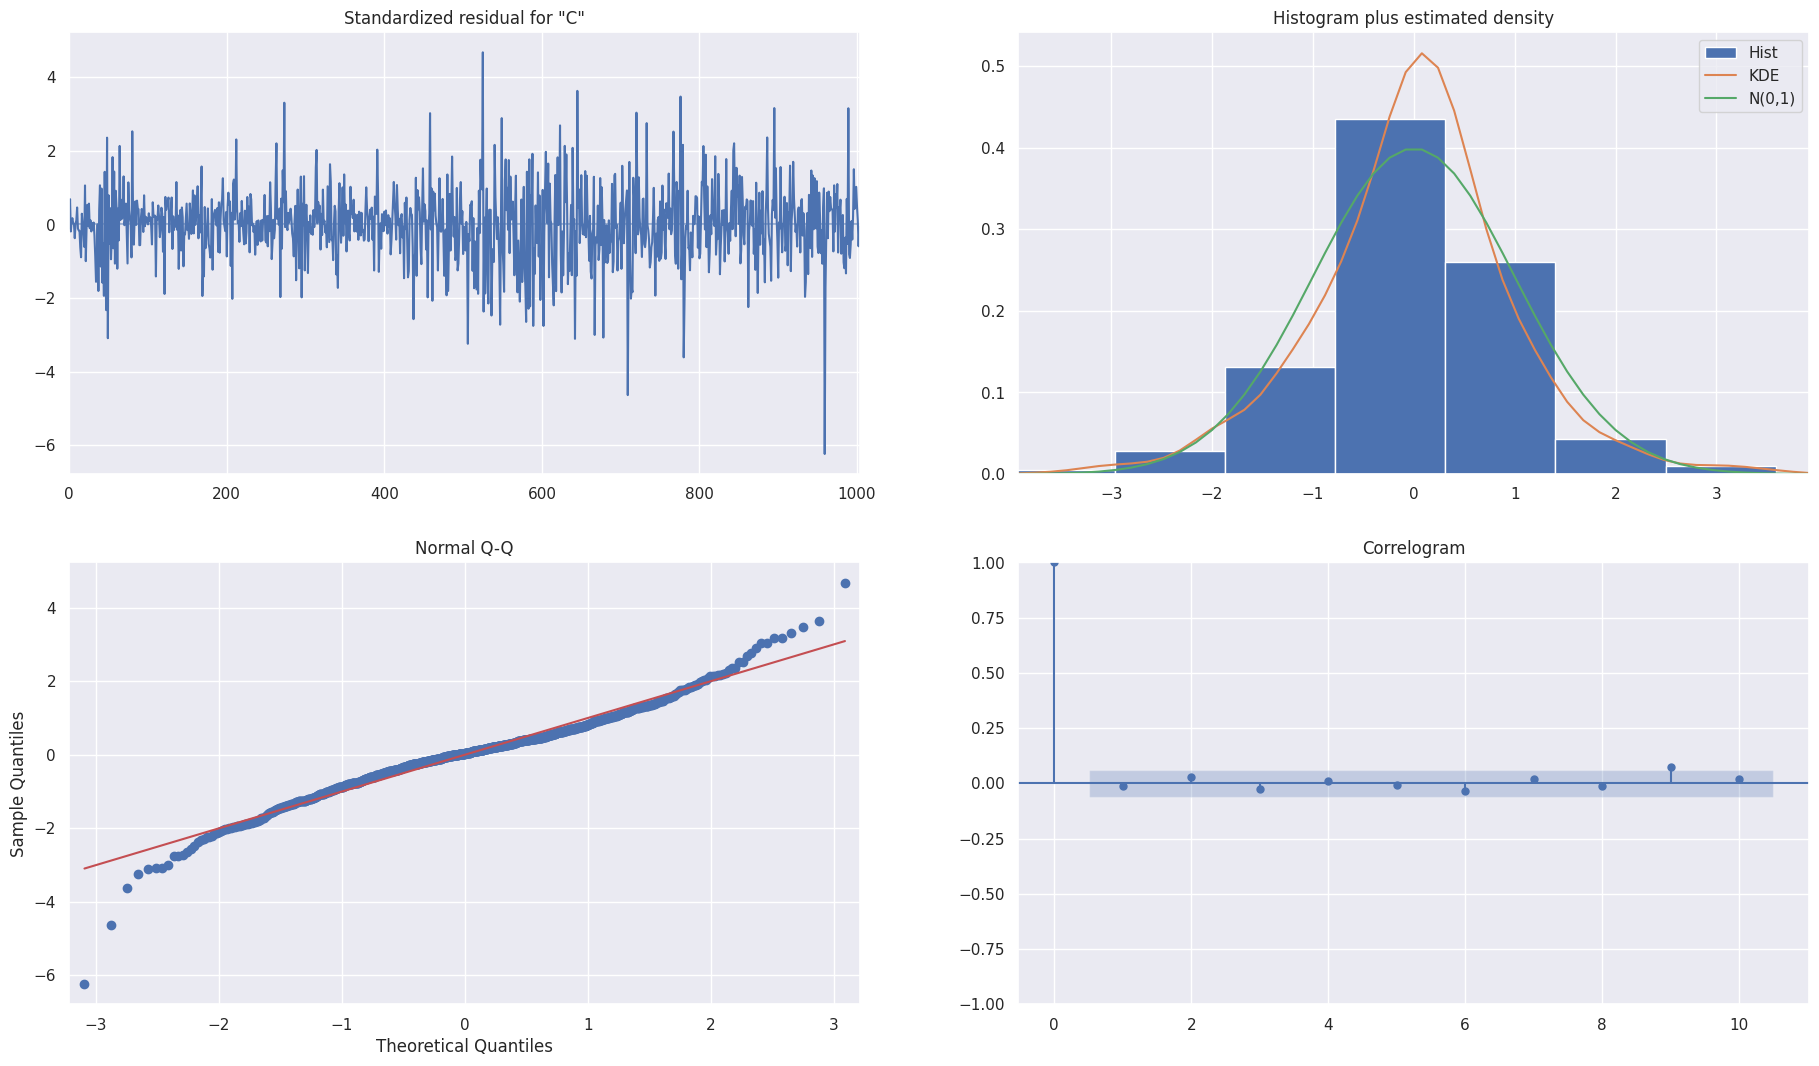

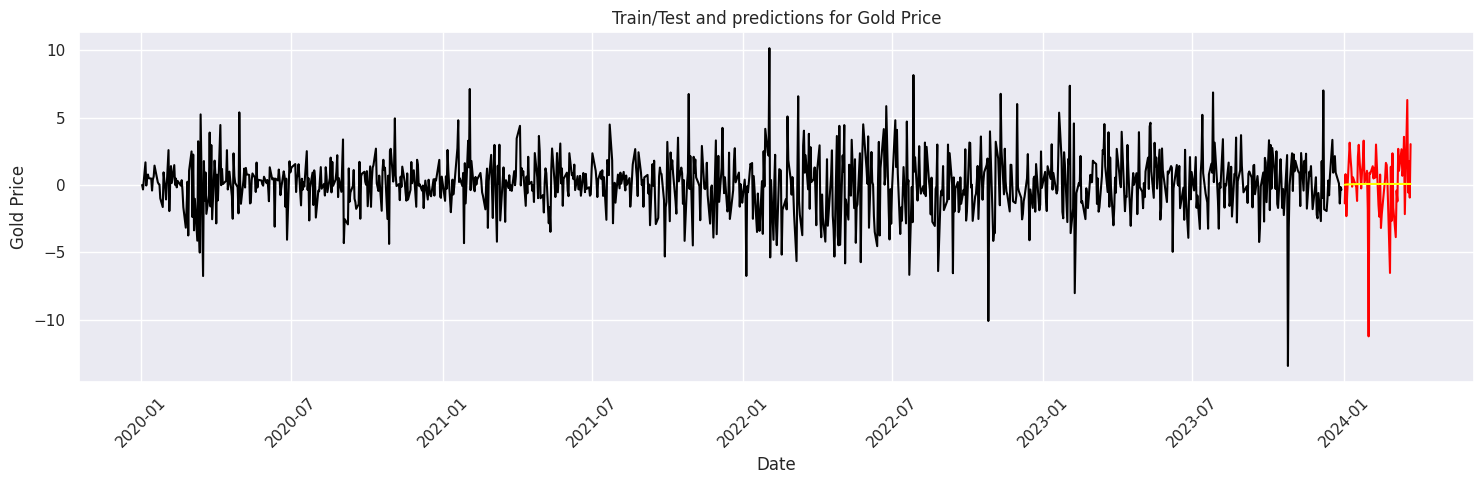

In [24]:
check_order(1,1,2)

After checking standard orders, we found that none of the orders are predicting the Google price well.

# SARIMA

In [25]:

def check_seasonal_order(p,d,q):
    y = data['Close_diff']
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    SARIMAmodel = SARIMAX(y, order = (p,d,q),seasonal_order = (0,0,0,12))
    ResultModel = SARIMAmodel.fit()
    print(ResultModel.summary(),"\n")

    y_pred = ResultModel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df["Predictions"] = ResultModel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"]


    from sklearn.metrics import mean_squared_error
    sarima_rmse = np.sqrt(mean_squared_error(test['Close_diff'].values, y_pred_df["Predictions"]))
    print("RMSE: ",sarima_rmse,'\n')

    ResultModel.plot_diagnostics(figsize = (20,12))


    sns.set()
    plt.subplots(figsize = (15,10))
    plt.plot(train,color ='black',label = 'Train')
    plt.plot(test,color = 'red',label = 'Test')
    plt.plot(y_pred_out, color='green', label = 'ARIMA Predictions')
    plt.ylabel("Gooogle Price")
    plt.xlabel("Date")
    plt.xticks(rotation = 45)
    plt.title("Train/Test and predictions for Gold Price")
    plt.show()

## check_seasonal_order(2,1,2)

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1063
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2341.558
Date:                Wed, 27 Mar 2024   AIC                           4693.115
Time:                        02:53:57   BIC                           4717.955
Sample:                             0   HQIC                          4702.528
                               - 1063                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0377      0.028    -37.701      0.000      -1.092      -0.984
ar.L2         -0.0411      0.027     -1.500      0.134      -0.095       0.013
ma.L1      -5.434e-05      0.222     -0.000      1.0

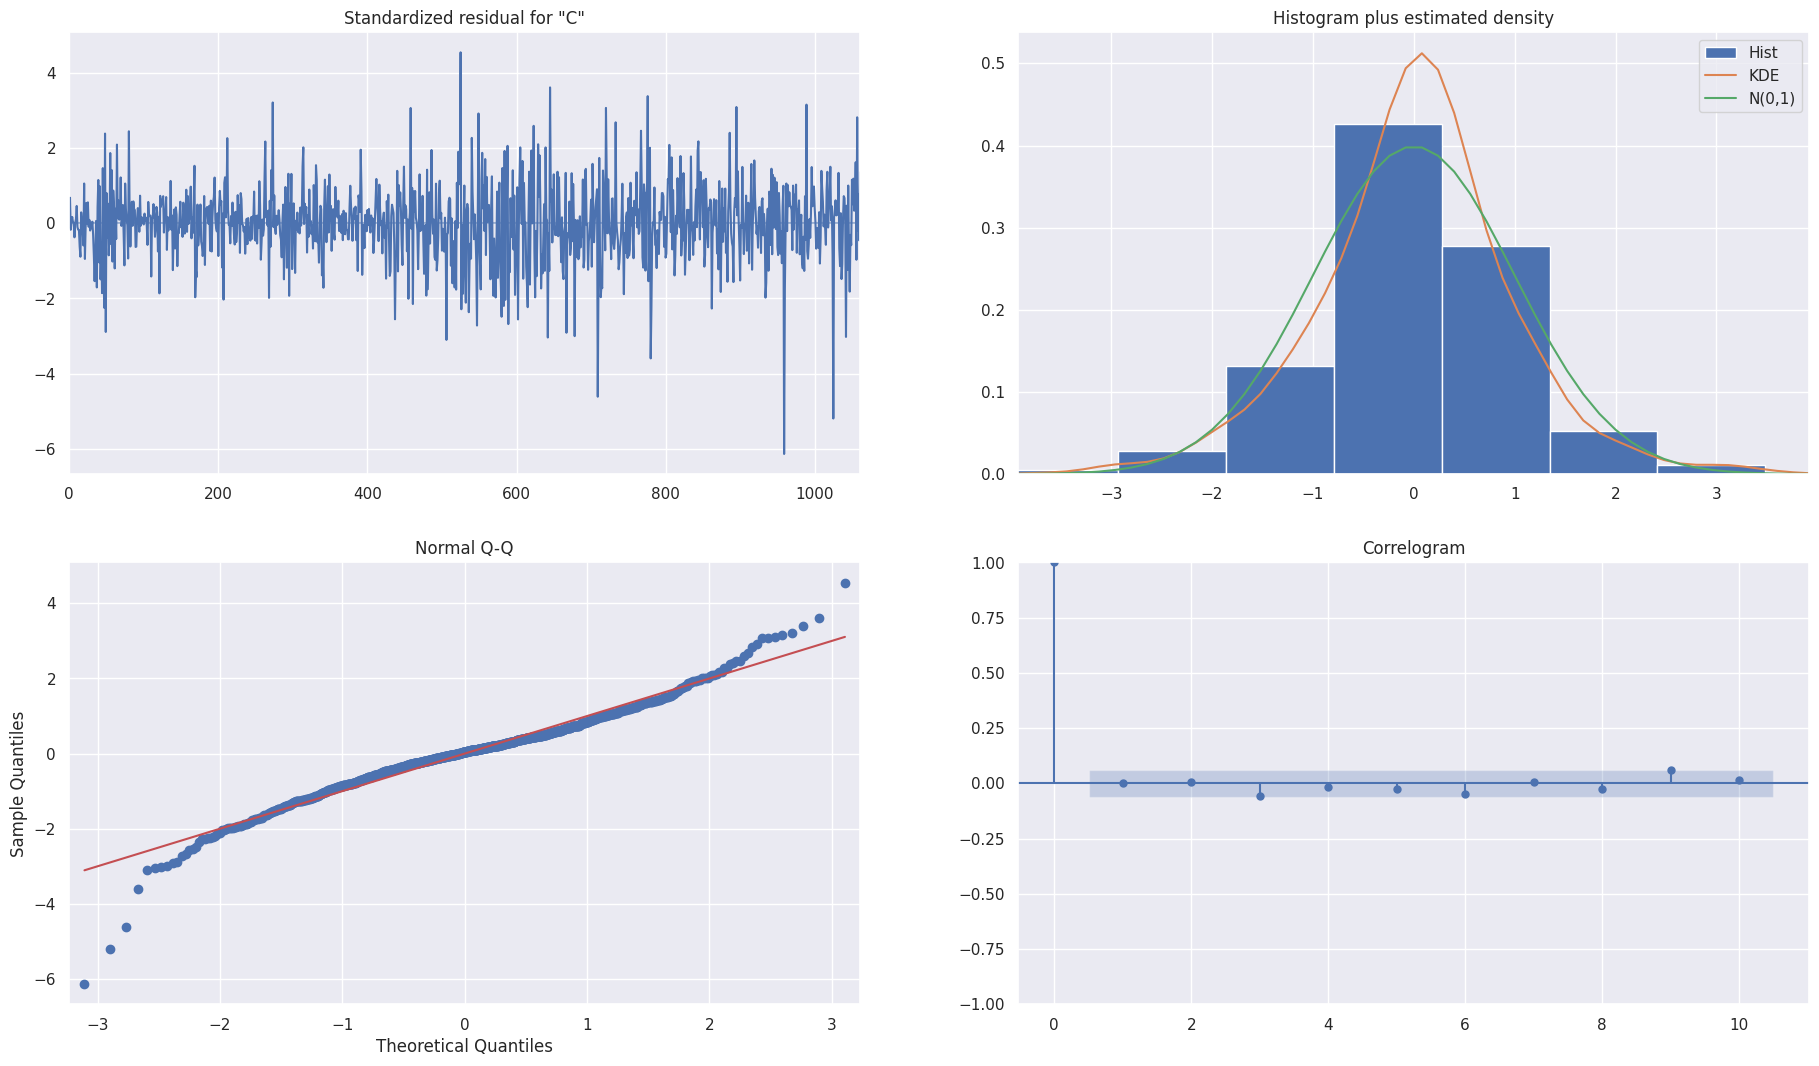

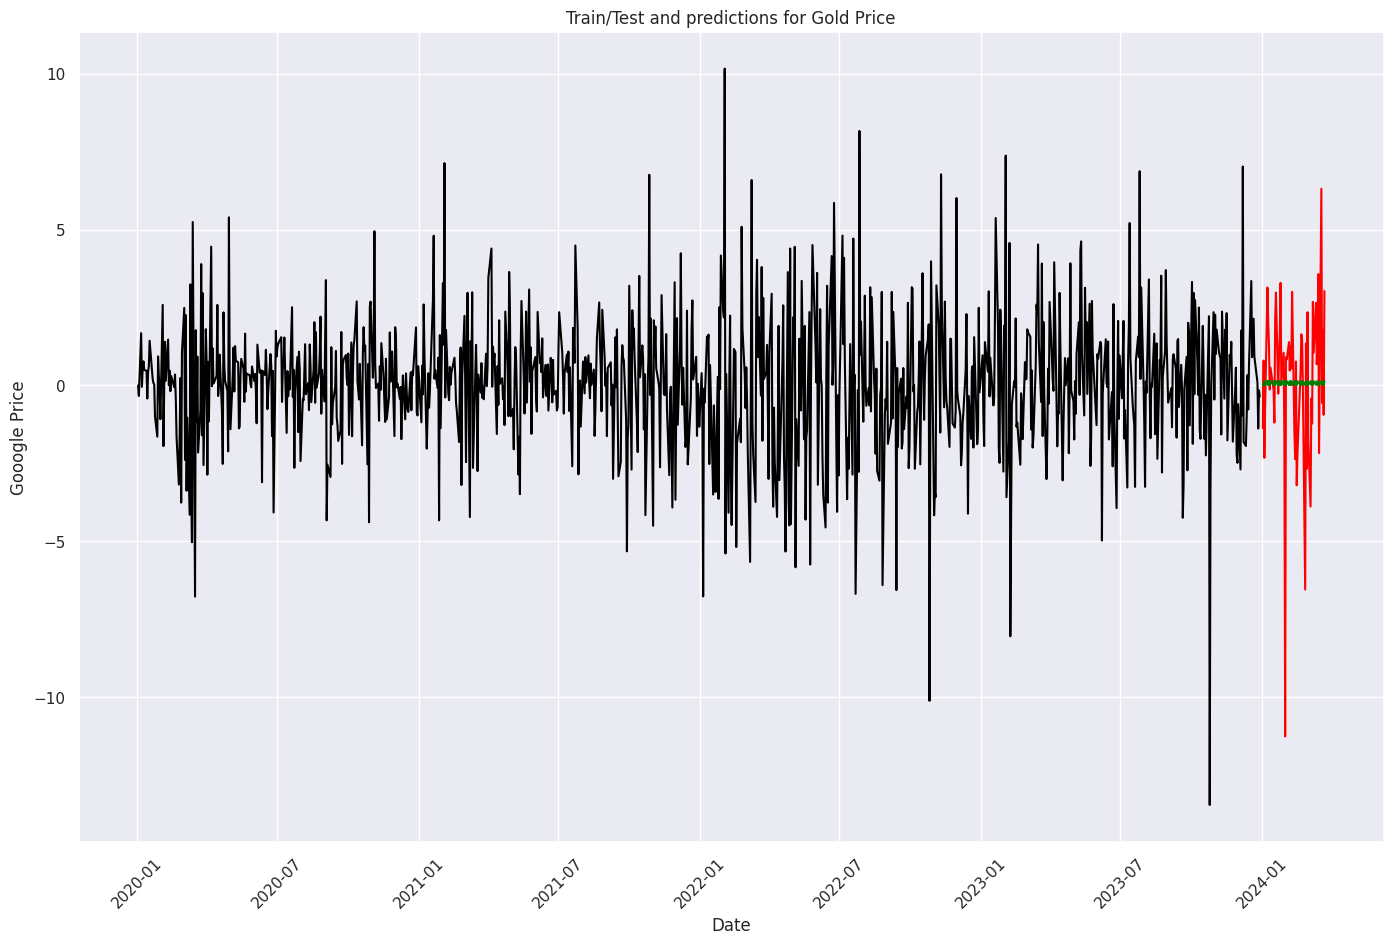

In [26]:
check_seasonal_order(2,1,2)

## check_seasonal_order(1,0,1)

                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1063
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2340.548
Date:                Wed, 27 Mar 2024   AIC                           4687.096
Time:                        02:54:00   BIC                           4702.002
Sample:                             0   HQIC                          4692.744
                               - 1063                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5336      0.412     -1.294      0.196      -1.342       0.275
ma.L1          0.4941      0.421      1.173      0.241      -0.332       1.320
sigma2         4.7864      0.129     37.198      0.0

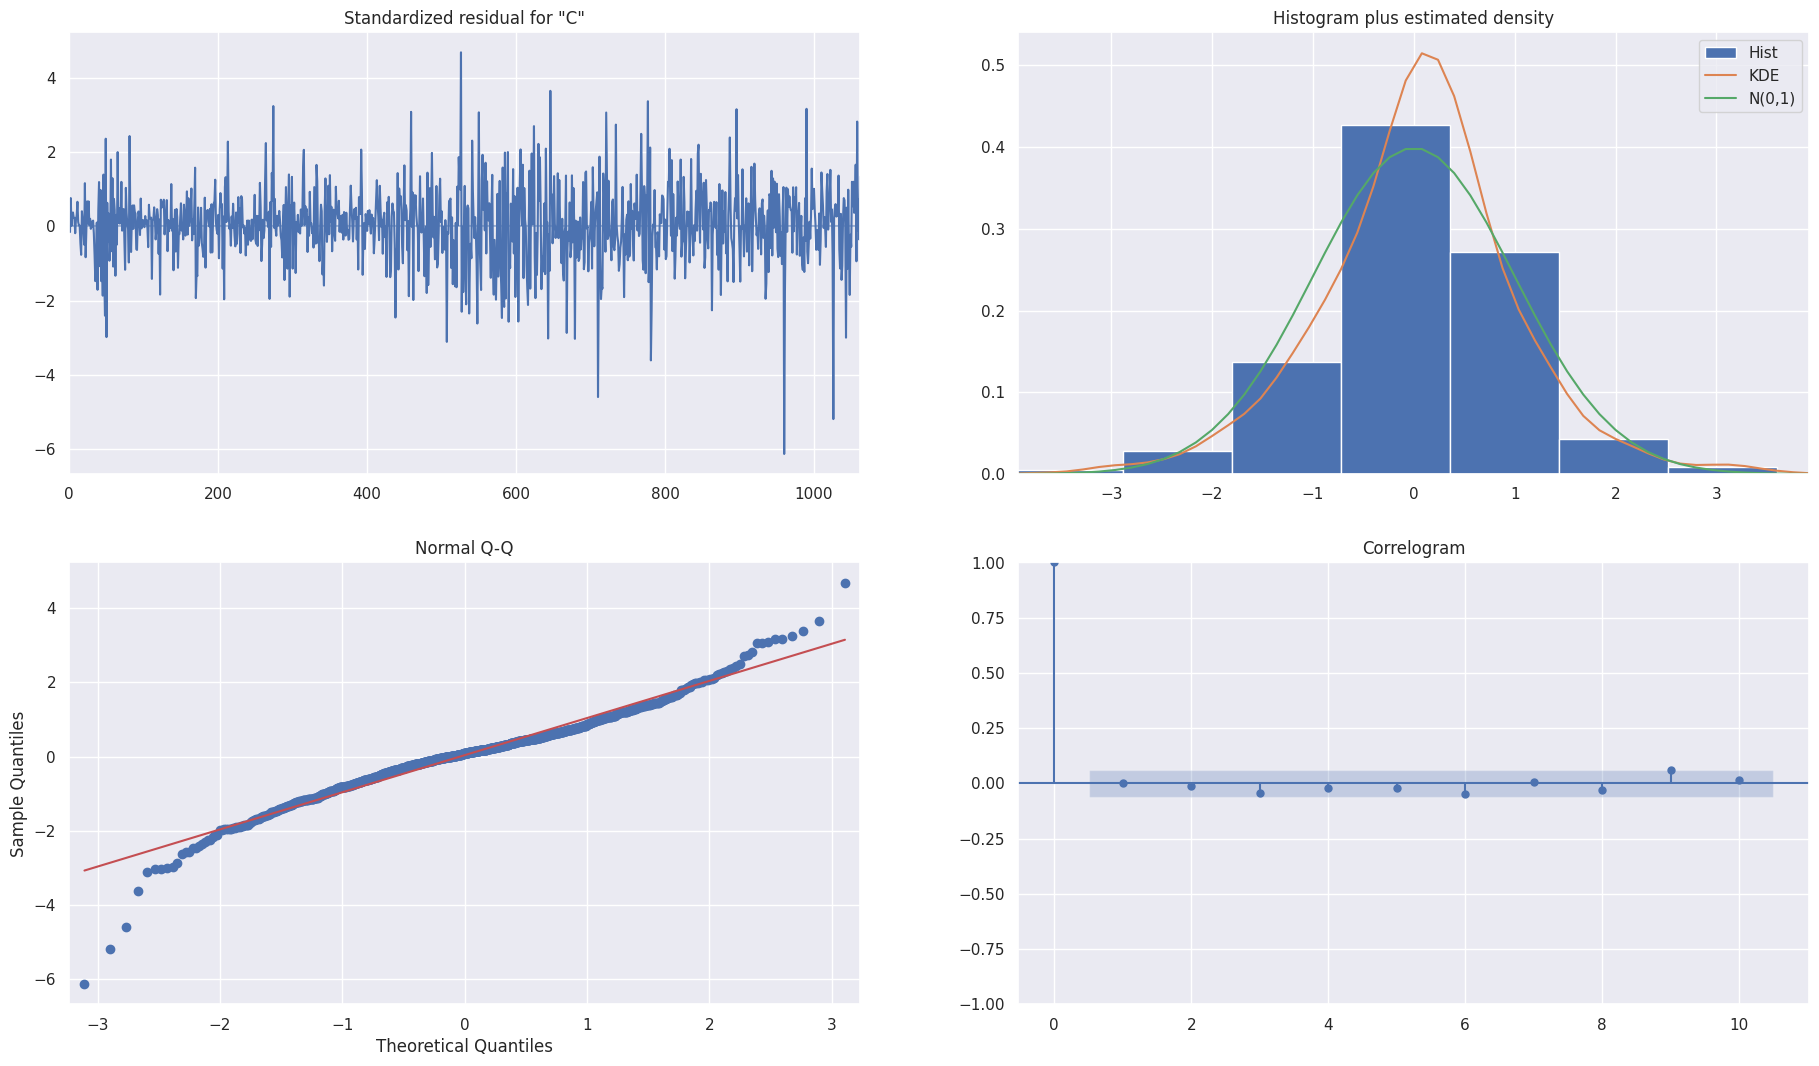

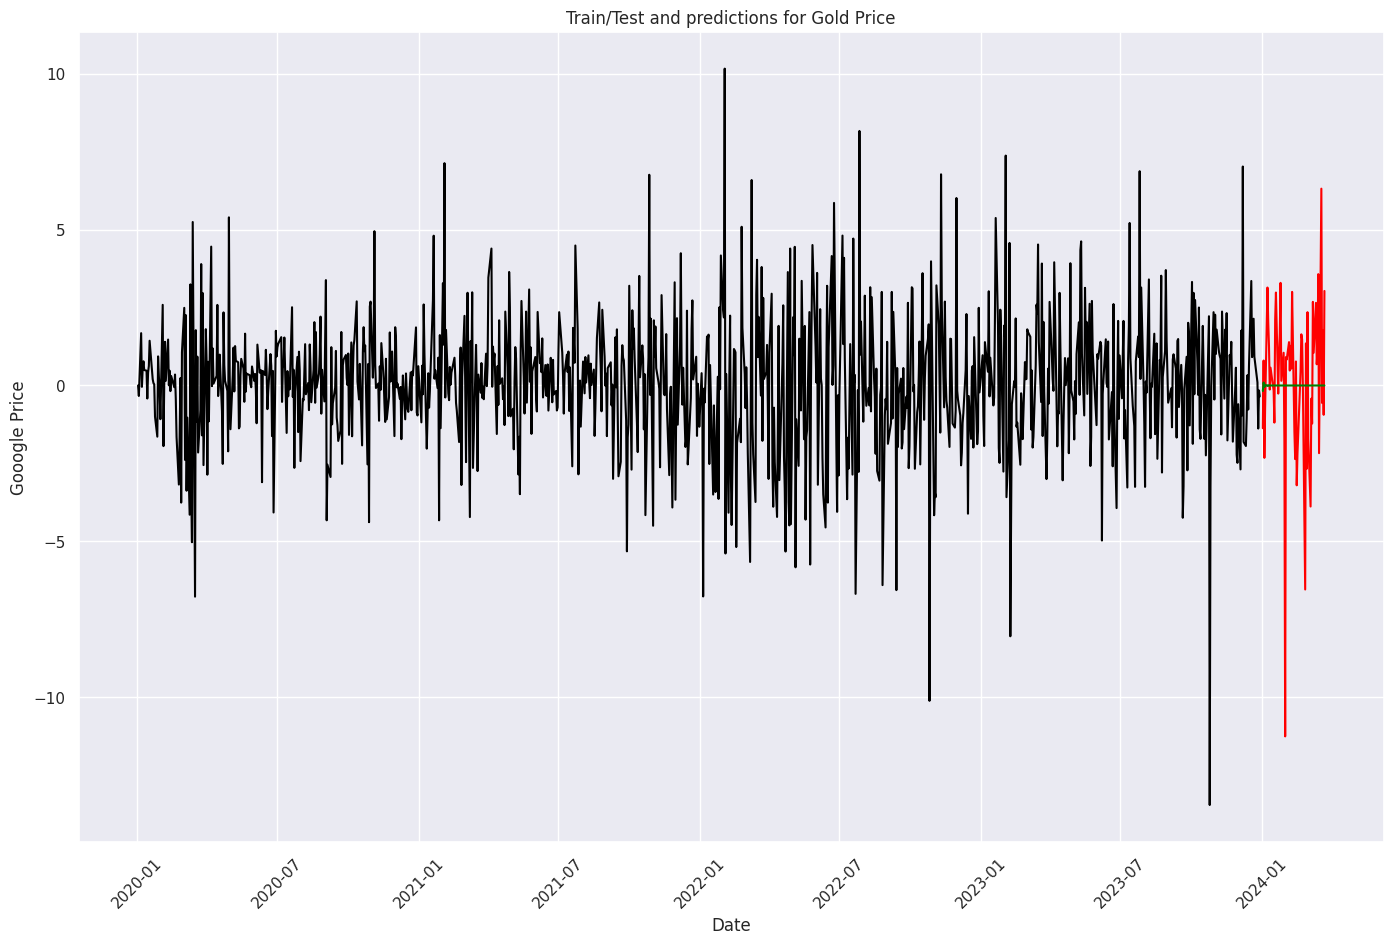

In [27]:
check_seasonal_order(1,0,1)

In [28]:
data.head(10)

Close  Close_log  Close_diff
Date                                        
2020-01-02  68.368500   4.224912    0.000000
2020-01-03  68.032997   4.219993   -0.335503
2020-01-06  69.710503   4.244351    1.677505
2020-01-07  69.667000   4.243727   -0.043503
2020-01-08  70.216003   4.251576    0.549004
2020-01-09  70.991501   4.262560    0.775497
2020-01-10  71.486504   4.269509    0.495003
2020-01-13  71.961502   4.276131    0.474998
2020-01-14  71.543999   4.270313   -0.417503
2020-01-15  71.959999   4.276110    0.416000

## Conclusion

Then in this exercise of having implemented ARIMA and SARIMA models are powerful tools for modeling and predicting time series, they may not be the most suitable for predicting future stock values due to the complexity and non-stationary nature of the stock market, as well as the lack of consideration of relevant exogenous variables.


# Another approach to the time series

## Features with Prophet library

In [29]:
! pip install prophet #Prophet is a procedure for forecasting time series data based on an additive mode

In [30]:
today = date.today()
end_date = "2024-03-25"

d1 = date.today() - timedelta(days=1460)
start_date = "2020-01-01"

data1 = yf.download('GOOG',
                      start=start_date,
                      end=end_date,
                      progress=False)
data1["Date"] = data.index
df = data1[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df.reset_index(drop=True, inplace=True)
print(df.tail())

           Date        Open        High         Low       Close   Adj Close  \
1058 2024-03-18  149.369995  152.929993  148.139999  148.479996  148.479996   
1059 2024-03-19  148.979996  149.619995  147.009995  147.919998  147.919998   
1060 2024-03-20  148.789993  149.759995  147.664993  149.679993  149.679993   
1061 2024-03-21  150.320007  151.304993  148.009995  148.740005  148.740005   
1062 2024-03-22  150.240005  152.559998  150.089996  151.770004  151.770004   

        Volume  
1058  47676700  
1059  17748400  
1060  17730000  
1061  19843900  
1062  19226300  


In [31]:
time_data = data1[["Date",'Close']]
time_data.columns = ['ds','y']
time_data.head()

ds          y
Date                            
2020-01-02 2020-01-02  68.368500
2020-01-03 2020-01-03  68.032997
2020-01-06 2020-01-06  69.710503
2020-01-07 2020-01-07  69.667000
2020-01-08 2020-01-08  70.216003

In [32]:
from prophet import Prophet
m = Prophet(daily_seasonality=True)
model_fit = m.fit(time_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/ubfft3ji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/49c9vjj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35513', 'data', 'file=/tmp/tmph3kpcxp8/ubfft3ji.json', 'init=/tmp/tmph3kpcxp8/49c9vjj9.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_model5p4blzxc/prophet_model-20240327025409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
forecast = model_fit.predict(time_data)
forecast[['ds','yhat','yhat_upper','yhat_lower']].tail()

ds        yhat  yhat_upper  yhat_lower
1058 2024-03-18  145.540398  150.513499  139.697481
1059 2024-03-19  145.921342  150.924789  140.522030
1060 2024-03-20  146.426731  151.714976  140.861150
1061 2024-03-21  146.935714  152.360857  141.689539
1062 2024-03-22  147.321877  152.330678  141.857317

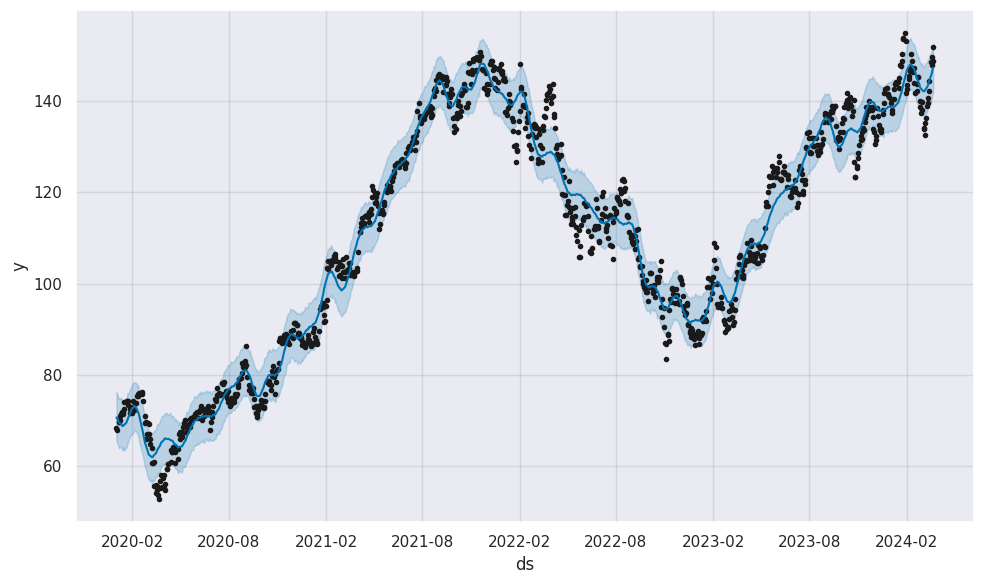

In [34]:
model_fit.plot(forecast);


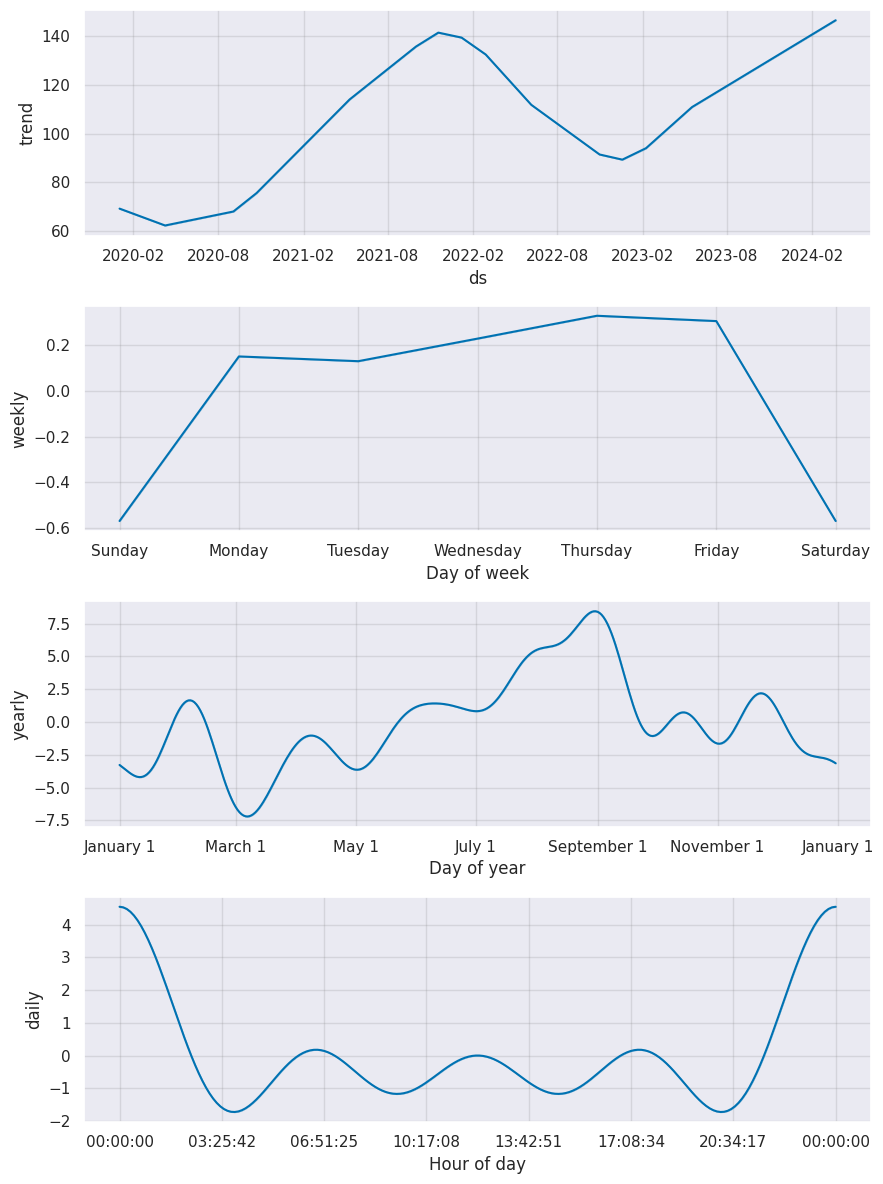

In [35]:
model_fit.plot_components(forecast);

## Forecasting for next 30 days

In [36]:
m2 = Prophet(daily_seasonality=True)
m2.fit(time_data)
future = m2.make_future_dataframe(periods = 30)
future.tail(10)

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/vhw5uvn3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/di7tznjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45587', 'data', 'file=/tmp/tmph3kpcxp8/vhw5uvn3.json', 'init=/tmp/tmph3kpcxp8/di7tznjh.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modeljuac5dcu/prophet_model-20240327025414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
1083 2024-04-12
1084 2024-04-13
1085 2024-04-14
1086 2024-04-15
1087 2024-04-16
1088 2024-04-17
1089 2024-04-18
1090 2024-04-19
1091 2024-04-20
1092 2024-04-21

In [37]:
forecast2 = m2.predict(future)
forecast2[['ds','yhat','yhat_upper','yhat_lower']].tail()

ds        yhat  yhat_upper  yhat_lower
1088 2024-04-17  152.495670  157.746680  146.810256
1089 2024-04-18  152.546122  158.024728  147.271778
1090 2024-04-19  152.467606  157.868375  147.323956
1091 2024-04-20  151.537676  156.985129  146.266367
1092 2024-04-21  151.478879  156.757262  146.097975

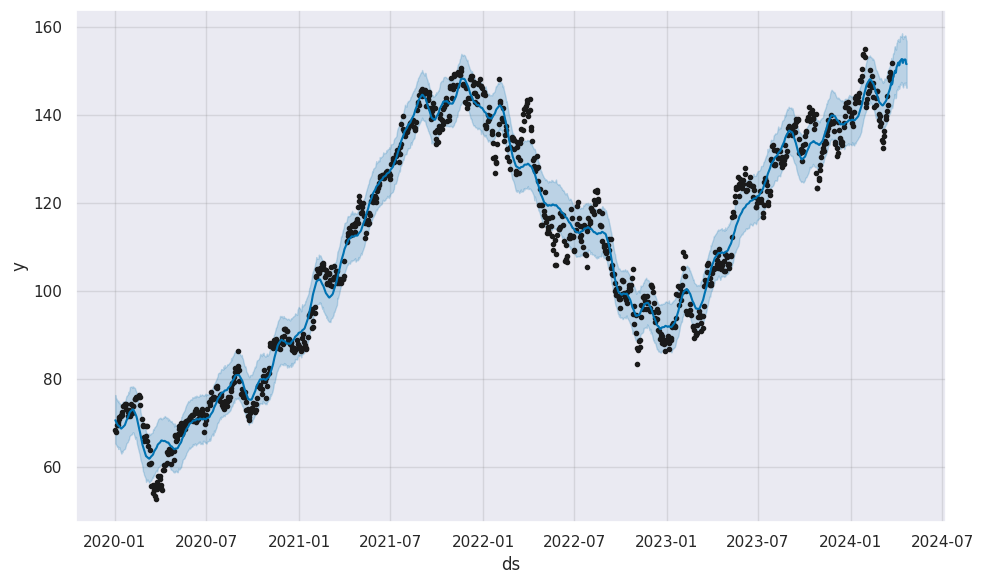

In [38]:
m2.plot(forecast2);

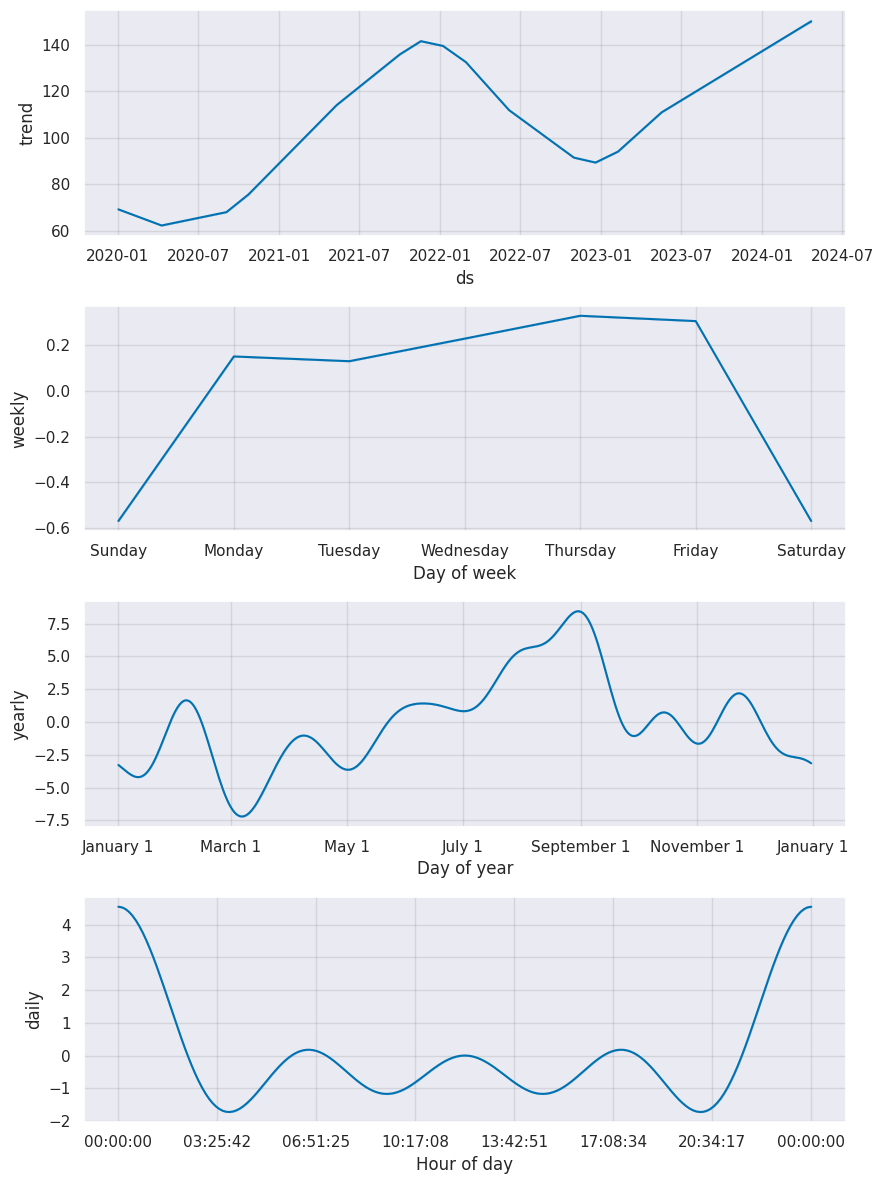

In [39]:
m2.plot_components(forecast2);

In [40]:
predictions = forecast2[['ds','yhat']]
predictions = predictions.rename(columns = {'ds':'Date','yhat':'Close Google Price'})
predictions.tail(30)

Date  Close Google Price
1063 2024-03-23          146.857301
1064 2024-03-24          147.259096
1065 2024-03-25          148.370882
1066 2024-03-26          148.735416
1067 2024-03-27          149.207771
1068 2024-03-28          149.667957
1069 2024-03-29          149.990426
1070 2024-03-30          149.448133
1071 2024-03-31          149.759064
1072 2024-04-01          150.767734
1073 2024-04-02          151.017814
1074 2024-04-03          151.365334
1075 2024-04-04          151.691310
1076 2024-04-05          151.871266
1077 2024-04-06          151.179311
1078 2024-04-07          151.334681
1079 2024-04-08          152.183240
1080 2024-04-09          152.270123
1081 2024-04-10          152.452926
1082 2024-04-11          152.614345
1083 2024-04-12          152.631677
1084 2024-04-13          151.780886
1085 2024-04-14          151.783123
1086 2024-04-15          152.486203
1087 2024-04-16          152.437212
1088 2024-04-17          152.495670
1089 2024-04-18          152.546122
1090 2024-04-19          152.467606
1091 2024-04-20          151.537676
1092 2024-04-21          151.478879

## Vizualization of the results features for the nex 30 days

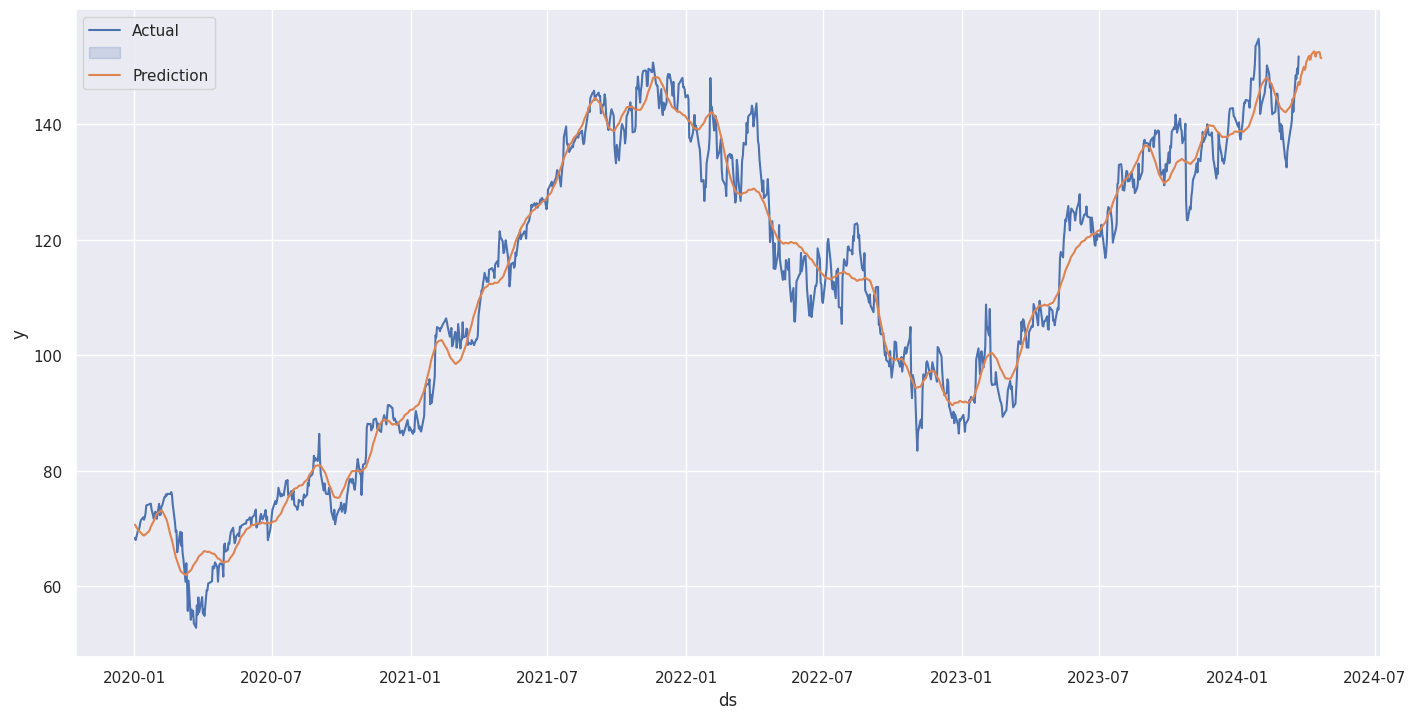

In [41]:
plt.subplots(figsize = (15,8))
sns.lineplot(time_data,x = 'ds',y='y',legend='full')
sns.lineplot(predictions,x = 'Date',y = 'Close Google Price',legend='full')
plt.legend(labels = ['Actual','','Prediction'])
plt.show()

In [42]:
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Perform cross-validation
df_cv = cross_validation(m2, initial='1000 days', period='200 days', horizon='365 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

INFO:prophet:Making 1 forecasts with cutoffs between 2023-03-23 00:00:00 and 2023-03-23 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/8_73hbyy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/h_x_5a9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63273', 'data', 'file=/tmp/tmph3kpcxp8/8_73hbyy.json', 'init=/tmp/tmph3kpcxp8/h_x_5a9o.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modeldw8m1ziq/prophet_model-20240327025424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error: 49.51
Mean Squared Error: 2875.12
Root Mean Squared Error: 53.62


In [43]:
df_cv.head()

ds       yhat  yhat_lower  yhat_upper           y     cutoff
0 2023-03-24  94.366691   89.702831   99.292177  106.059998 2023-03-23
1 2023-03-27  94.435127   88.956563   99.510939  103.059998 2023-03-23
2 2023-03-28  94.431506   89.448480   99.892896  101.360001 2023-03-23
3 2023-03-29  94.677828   89.695921   99.686677  101.900002 2023-03-23
4 2023-03-30  94.637720   89.364856   99.529278  101.320000 2023-03-23

## Hyperparameter Tuning


In [44]:
from prophet.diagnostics import cross_validation
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Define the hyperparameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1, 10, 30],
}


# Helper function to evaluate the model
def evaluate_model(model, metric_func):
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    return metric_func(df_cv['y'], df_cv['yhat'])


# Grid search
best_params = {}
best_score = float('inf')

for mode in param_grid['seasonality_mode']:
    for cps in param_grid['changepoint_prior_scale']:
        for sps in param_grid['seasonality_prior_scale']:
            # Create a model with the current hyperparameters
            model = Prophet(seasonality_mode=mode, changepoint_prior_scale=cps, seasonality_prior_scale=sps)
            model.fit(time_data)

            # Evaluate the model using Mean Absolute Error (MAE)
            score = evaluate_model(model, mean_absolute_error)

            # Update best parameters if necessary
            if score < best_score:
                best_score = score
                best_params = {
                    'seasonality_mode': mode,
                    'changepoint_prior_scale': cps,
                    'seasonality_prior_scale': sps
                }

print(best_params)
print(best_score)

# Create the best model with the optimal hyperparameters
best_model = Prophet(**best_params)
best_model.fit(time_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/1oi5rqmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/10k44faz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75492', 'data', 'file=/tmp/tmph3kpcxp8/1oi5rqmj.json', 'init=/tmp/tmph3kpcxp8/10k44faz.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelde0kkdxy/prophet_model-20240327025427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2022-03-28 00:00:00 and 2023-03-23 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/yhfn6m4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/ojsrti56.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46833', 'data', 'file=/tmp/tmph3kpcxp8/yhfn6m4b.json', 'init=/tmp/tmph3kpcxp8/ojsrti56.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_model5sazlpdy/prophet_model-20240327025428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/t79_j39b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/z5gmtedk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/s85utdje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/rlt0e4lm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44021', 'data', 'file=/tmp/tmph3kpcxp8/s85utdje.json', 'init=/tmp/tmph3kpcxp8/rlt0e4lm.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelcerghwgl/prophet_model-20240327025432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/o7qsp72v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/plhutunt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/64be7slx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/wbxxgn0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85334', 'data', 'file=/tmp/tmph3kpcxp8/64be7slx.json', 'init=/tmp/tmph3kpcxp8/wbxxgn0s.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_model2vdvgvbh/prophet_model-20240327025435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/hko9hbvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/18bf_ers.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/1a3uhu40.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/wjnbip5x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9997', 'data', 'file=/tmp/tmph3kpcxp8/1a3uhu40.json', 'init=/tmp/tmph3kpcxp8/wjnbip5x.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_model01qz_xng/prophet_model-20240327025441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/9k_ni1gz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/zl4r8z3_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/ng9vpusp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/73td6snw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16057', 'data', 'file=/tmp/tmph3kpcxp8/ng9vpusp.json', 'init=/tmp/tmph3kpcxp8/73td6snw.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelcnyrf3r6/prophet_model-20240327025446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/ptyc1lb_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/hnzxepzb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/0k1axubl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/gbgmqyqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51907', 'data', 'file=/tmp/tmph3kpcxp8/0k1axubl.json', 'init=/tmp/tmph3kpcxp8/gbgmqyqj.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelfim4n9zx/prophet_model-20240327025452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/htzxn3sy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/he6hhpl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/qgc4rcyg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/8tqi9d30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92883', 'data', 'file=/tmp/tmph3kpcxp8/qgc4rcyg.json', 'init=/tmp/tmph3kpcxp8/8tqi9d30.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelhmgv4tfo/prophet_model-20240327025458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:54:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:54:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/noo5szrw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/hnad7e4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/yeua429g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/32p6b2ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12875', 'data', 'file=/tmp/tmph3kpcxp8/yeua429g.json', 'init=/tmp/tmph3kpcxp8/32p6b2ke.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelgw8j2j_h/prophet_model-20240327025502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/31s7a4_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/if60l_gl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/54gwyf53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/9rltrrgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65532', 'data', 'file=/tmp/tmph3kpcxp8/54gwyf53.json', 'init=/tmp/tmph3kpcxp8/9rltrrgl.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_model0ezkjyzw/prophet_model-20240327025506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/2y4l4zue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/i1y1io_c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/iy4_d_yk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/rwxh38zo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57433', 'data', 'file=/tmp/tmph3kpcxp8/iy4_d_yk.json', 'init=/tmp/tmph3kpcxp8/rwxh38zo.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_model1ong_qv6/prophet_model-20240327025509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/xcnj7_d9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/su_4i2uq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/hdbh1hnm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/rtgtdonw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74807', 'data', 'file=/tmp/tmph3kpcxp8/hdbh1hnm.json', 'init=/tmp/tmph3kpcxp8/rtgtdonw.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelfqipt7bk/prophet_model-20240327025511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/d4nuh13z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/z33gi7av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/ooy_1ekl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/knoq9b1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8187', 'data', 'file=/tmp/tmph3kpcxp8/ooy_1ekl.json', 'init=/tmp/tmph3kpcxp8/knoq9b1g.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelnsm2c0h1/prophet_model-20240327025513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/g8iz9a1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/242n392b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/sf0hk0hg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/04dpcrfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78633', 'data', 'file=/tmp/tmph3kpcxp8/sf0hk0hg.json', 'init=/tmp/tmph3kpcxp8/04dpcrfd.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelr8ffzeup/prophet_model-20240327025516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/vokxvwtp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/qrtdzgho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/qtenl4sl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/zwzpgbdt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9034', 'data', 'file=/tmp/tmph3kpcxp8/qtenl4sl.json', 'init=/tmp/tmph3kpcxp8/zwzpgbdt.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_model6tuu796w/prophet_model-20240327025521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/2u6pgtzf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/zcy9kbsf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/4i1tbkym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/qy02_qul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62617', 'data', 'file=/tmp/tmph3kpcxp8/4i1tbkym.json', 'init=/tmp/tmph3kpcxp8/qy02_qul.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelutfzy9dk/prophet_model-20240327025527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/234finvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/oa47ow67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/rfl3ue39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/n72aisuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72629', 'data', 'file=/tmp/tmph3kpcxp8/rfl3ue39.json', 'init=/tmp/tmph3kpcxp8/n72aisuz.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_model48ppiq7t/prophet_model-20240327025533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/6pfxd0n_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/wzejlyqk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/6usfx5ol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/gbhcu8vd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37357', 'data', 'file=/tmp/tmph3kpcxp8/6usfx5ol.json', 'init=/tmp/tmph3kpcxp8/gbhcu8vd.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelo1ni56ze/prophet_model-20240327025537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/8f670r74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/4hz3cqga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/1we3q8zx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/be5cw03p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47627', 'data', 'file=/tmp/tmph3kpcxp8/1we3q8zx.json', 'init=/tmp/tmph3kpcxp8/be5cw03p.json', 'output', 'file=/tmp/tmph3kpcxp8/prophet_modelvhsl19_y/prophet_model-20240327025543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/jbtg2aqp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3kpcxp8/8s_ic6rr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30}
44.96283343092213


02:55:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [45]:
print(best_params)
print(best_score)

{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30}
44.96283343092213
